In [2]:
from keras import layers
from keras.layers import Input, Dense, Reshape, Flatten, Embedding, Dropout
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2DTranspose, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils.generic_utils import Progbar
import numpy as np
import pandas as pd
from keras.layers.advanced_activations import LeakyReLU
import matplotlib.pyplot as plt
%matplotlib inline

/home/ejrueda/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### Esquema de una GANs
- Generator: es la red que se encarga de producir imágenes falsas, para tratar de engañar al discriminador.
- Discriminator: recibe imágenes falsas y reales, y se entrena para que pueda predecir la autencicidad de cada una.

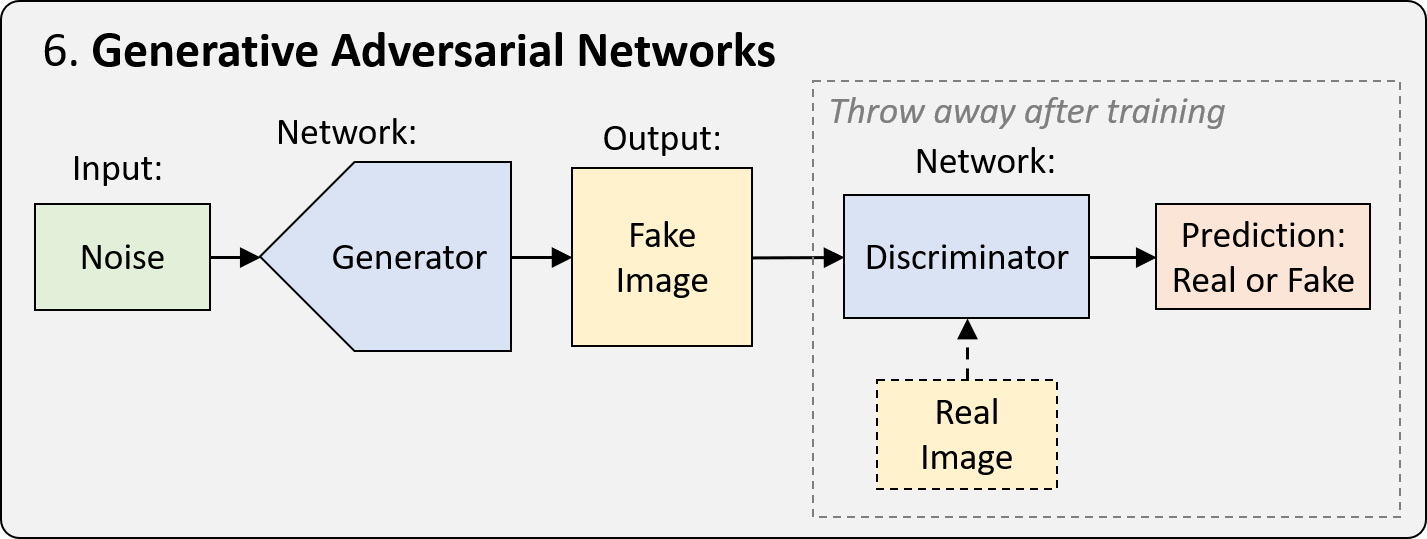

In [4]:
from IPython.display import Image
Image(filename="GANs_arquitectura.png")

#### Se carga el MNIST con el que se va a probar la arquitectura.

In [2]:
data_train = pd.read_csv("./data/train.csv")
data_test = pd.read_csv("./data/test.csv")
data_train.shape, data_test.shape

((42000, 785), (28000, 784))

In [3]:
data_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


-- Imágenes originales --


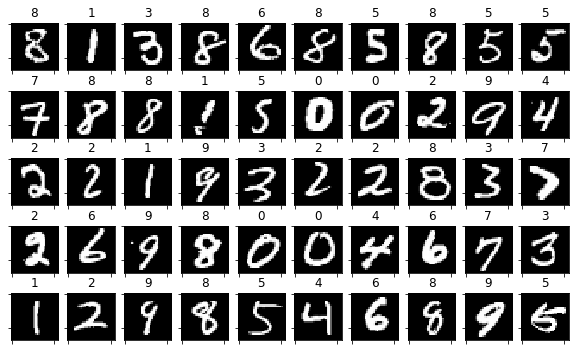

In [4]:
num_imgs = 50 #número de imágenes a mostrar aleatoriamente
fig = plt.figure(figsize=(10,6))
print("-- Imágenes originales --")
for i in range(num_imgs):
    ax=fig.add_subplot(5,10,i+1)
    rdm_img = np.random.randint(1,data_train.shape[0]-1)
    plt.imshow(np.array(data_train.iloc[rdm_img,1:]).reshape(28,28), cmap = plt.cm.Greys_r)
    ax.set_title(int(data_train.iloc[rdm_img,0]))
    ax.set_xticklabels([])
    ax.set_yticklabels([])

#### Ejemplo del generador de ruido:
- se generan imágenes a partir de una distribución gausiana, para con ellas estimar la nuevas imágenes.

In [5]:
#se crea el modelo secuencial el cual hará las veces de generador de ruido
model = Sequential()
model.add(Dense(256, input_shape=(100,)))
model.add(LeakyReLU(alpha=0.2)) #función rectificadora
model.add(Dropout(0.1))
model.add(BatchNormalization(momentum=0.8)) #normalización de las capas anteriores
model.add(Dense(512))
model.add(LeakyReLU(alpha=0.2))
model.add(BatchNormalization(momentum=0.8))
model.add(Dense(1024))
model.add(Dropout(0.1))
model.add(LeakyReLU(alpha=0.2))
model.add(BatchNormalization(momentum=0.8))
model.add(Dense(28  * 28 * 1, activation='tanh'))
model.add(Reshape((28, 28, 1)))
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5, decay=8e-8))

In [11]:
#model.summary()
batch = 640
gen_noise = np.random.normal(0, 1, (np.int64(batch/2), 100))
syntetic_images = model.predict(gen_noise)
print("Imágenes: ",syntetic_images.shape)

Imágenes:  (320, 28, 28, 1)


imágenes que genera el modelo


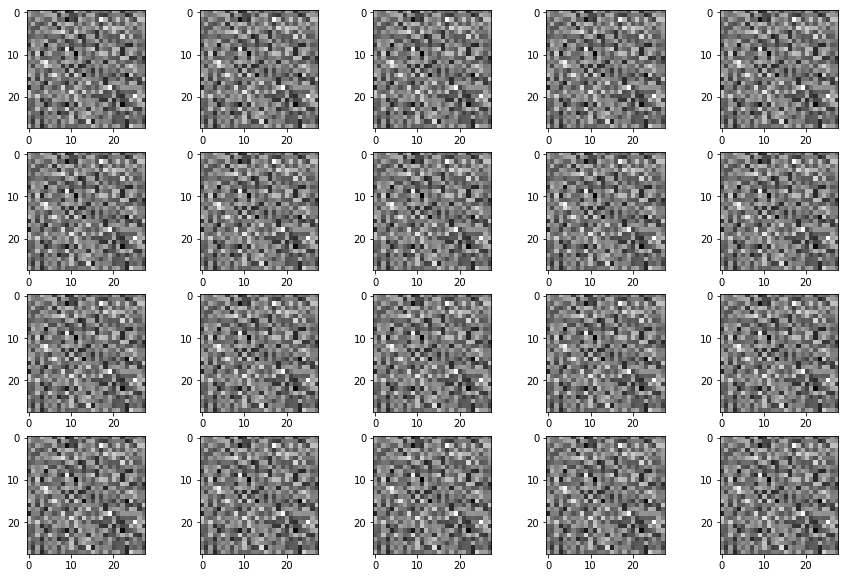

In [12]:
num_imgs = 20
plt.figure(figsize=(15,10))
print("imágenes que genera el modelo")
for i in range(num_imgs):
    plt.subplot(4,5,i+1)
    img_idx = np.random.randint(0,syntetic_images.shape[0])
    plt.imshow(syntetic_images[0,:,:].reshape(28,28), cmap="gray")

## Generative Adversarial Networks - GANs
- Se crea una clase llamada "GANs" y en ella se define tanto el generador como el discriminador, tambien el método para unir los dos modelos "__stacked_generator_discriminator". Por último se crea el método train el cual entrena la red.

In [13]:
import os
import numpy as np
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam

class GANs:
    #inicialización de variables
    def __init__(self, width=28, height=28, channels=1):
        #para retornar las imágenes
        self.WIDTH = width
        self.HEIGHT = height
        self.CHANNELS = channels
        self.SHAPE = (width, height, channels)
        #self.optimizer = Adam(lr=0.0001, beta_1=0.5, decay=8e-8)
        self.optimizer = Adam(lr=0.0001, beta_1=0.5)
        self.G = self.noise_generator()
        self.G.compile(loss='binary_crossentropy', optimizer=self.optimizer)
        #print("Compilando el generador...")
        self.D = self.discriminator()
        self.D.compile(loss='binary_crossentropy', optimizer=self.optimizer, metrics=['accuracy'])
        #print("Compilando el discriminador...")
        self.stacked_generator_discriminator = self.__stacked_generator_discriminator()
        self.stacked_generator_discriminator.compile(loss='binary_crossentropy', optimizer=self.optimizer)
        
    #Para unir el generador y el disctiminador
    def __stacked_generator_discriminator(self):
        self.D.trainable = False
        model = Sequential()
        model.add(self.G)
        model.add(self.D)
        return model
    
    #generador de ruido
    def noise_generator(self):
        model = Sequential()
        model.add(Dense(256, input_shape=(100,)))
        model.add(LeakyReLU(alpha=0.2)) #función rectificadora
        #model.add(Dropout(0.1))
        model.add(BatchNormalization(momentum=0.8)) #normalización de las capas anteriores
        model.add(Dense(512))
        #model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        #model.add(Dropout(0.1))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(self.WIDTH  * self.HEIGHT * self.CHANNELS, activation='tanh'))
        model.add(Reshape((self.WIDTH, self.HEIGHT, self.CHANNELS)))
        return model

    #Discriminador del modelo
    def discriminator(self):    
        model = Sequential()
        model.add(Flatten(input_shape=self.SHAPE))
        model.add(Dense((self.WIDTH * self.HEIGHT * self.CHANNELS), input_shape=self.SHAPE))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(np.int64((self.WIDTH * self.HEIGHT * self.CHANNELS)/2)))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(Dropout(0.1))
        model.add(Dense(1, activation='sigmoid'))
        #model.summary()
        return model
    
    #Entrenar la GANs
    def train(self, X_train, epochs, batch):
        ## train discriminator
        Imgs = []
        for cnt in range(epochs):
            random_index = np.random.randint(0, len(X_train) - np.int64(batch/2))
            legit_images = X_train[random_index:random_index + np.int64(batch/2)].reshape(np.int64(batch/2),
                                                                                            self.WIDTH,
                                                                                            self.HEIGHT,
                                                                                            self.CHANNELS)
            gen_noise = np.random.normal(0, 1, (np.int64(batch/2), 100))
            #print(gen_noise.shape)
            syntetic_images = self.G.predict(gen_noise)
            #print(legit_images.shape, syntetic_images.shape)
            x_combined_batch = np.concatenate((legit_images, syntetic_images))
            y_combined_batch = np.concatenate((np.ones((np.int64(batch/2), 1)),
                                               np.zeros((np.int64(batch/2), 1))))

            d_loss = self.D.train_on_batch(x_combined_batch, y_combined_batch)


            # train generator
            noise = np.random.normal(0, 1, (batch, 100))
            y_mislabled = np.ones((batch, 1))

            g_loss = self.stacked_generator_discriminator.train_on_batch(noise, y_mislabled)

            print ('epoch: %d, [Discriminator :: d_loss: %f], [ Generator :: loss: %f]' % (cnt, d_loss[0],
                                                                                           g_loss))
            #bined_batch = np.concatenate((np.ones((np.int64(batch/2), 1)), np.zeros((np.int64(batch/2), 1))))
            if (cnt % 100) ==0: #para dibujar solos módulos de 100
                Imgs.append(self.plot_images(save2file=True, samples=20, step=cnt))
                print(np.array(Imgs).shape)
        return Imgs
            
    def plot_images(self, save2file=False, samples=20, step=0):
        # Para pintar o guardar las imágenes
        if not os.path.exists("./images"):
            os.makedirs("./images")
        filename = "./images/mnist_" + str(step) + ".png"
        noise = np.random.normal(0, 1, (samples, 100))

        images = self.G.predict(noise)
        #print(images.shape)
        plt.figure(figsize=(10, 10))

        for i in range(images.shape[0]):
            plt.subplot(4, 5, i+1)
            image = images[i, :, :, :]
            image = np.reshape(image, [self.HEIGHT, self.WIDTH])
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        plt.tight_layout()

        if save2file:
            plt.savefig(filename)
            plt.close('all')
        else:
            plt.show()
        return images

In [14]:
X_train = np.array(data_train.iloc[:,1:])
y_train = np.array(data_train.iloc[:,0])

In [15]:
m = 255/2
X_train = (X_train.astype(np.float32) - m) / m
X_train = np.expand_dims(X_train, axis=3)

/home/ejrueda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
#np.expand_dims - Para expandir las dimensiones de un array

In [18]:
gan = GANs()
l_img = gan.train(X_train,epochs=10000,batch=128)

/home/ejrueda/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch: 0, [Discriminator :: d_loss: 1.016580], [ Generator :: loss: 0.771952]
(1, 20, 28, 28, 1)
epoch: 1, [Discriminator :: d_loss: 0.681829], [ Generator :: loss: 0.784118]
epoch: 2, [Discriminator :: d_loss: 0.447051], [ Generator :: loss: 0.781203]
epoch: 3, [Discriminator :: d_loss: 0.370337], [ Generator :: loss: 0.808137]
epoch: 4, [Discriminator :: d_loss: 0.354389], [ Generator :: loss: 0.875547]
epoch: 5, [Discriminator :: d_loss: 0.329527], [ Generator :: loss: 0.960361]
epoch: 6, [Discriminator :: d_loss: 0.280882], [ Generator :: loss: 1.028043]
epoch: 7, [Discriminator :: d_loss: 0.261156], [ Generator :: loss: 1.110576]
epoch: 8, [Discriminator :: d_loss: 0.255273], [ Generator :: loss: 1.193569]
epoch: 9, [Discriminator :: d_loss: 0.222738], [ Generator :: loss: 1.271703]
epoch: 10, [Discriminator :: d_loss: 0.203022], [ Generator :: loss: 1.371953]
epoch: 11, [Discriminator :: d_loss: 0.186010], [ Generator :: loss: 1.427971]
epoch: 12, [Discriminator :: d_loss: 0.1712

epoch: 104, [Discriminator :: d_loss: 0.024487], [ Generator :: loss: 3.833671]
epoch: 105, [Discriminator :: d_loss: 0.021677], [ Generator :: loss: 3.949121]
epoch: 106, [Discriminator :: d_loss: 0.018832], [ Generator :: loss: 3.889868]
epoch: 107, [Discriminator :: d_loss: 0.017991], [ Generator :: loss: 3.924873]
epoch: 108, [Discriminator :: d_loss: 0.015733], [ Generator :: loss: 3.923899]
epoch: 109, [Discriminator :: d_loss: 0.019891], [ Generator :: loss: 3.942852]
epoch: 110, [Discriminator :: d_loss: 0.018764], [ Generator :: loss: 3.902338]
epoch: 111, [Discriminator :: d_loss: 0.020340], [ Generator :: loss: 3.887345]
epoch: 112, [Discriminator :: d_loss: 0.023271], [ Generator :: loss: 3.935884]
epoch: 113, [Discriminator :: d_loss: 0.021845], [ Generator :: loss: 3.928683]
epoch: 114, [Discriminator :: d_loss: 0.017248], [ Generator :: loss: 3.912131]
epoch: 115, [Discriminator :: d_loss: 0.022240], [ Generator :: loss: 3.947122]
epoch: 116, [Discriminator :: d_loss: 0.

epoch: 208, [Discriminator :: d_loss: 0.102203], [ Generator :: loss: 4.021147]
epoch: 209, [Discriminator :: d_loss: 0.088244], [ Generator :: loss: 3.922922]
epoch: 210, [Discriminator :: d_loss: 0.075972], [ Generator :: loss: 3.657094]
epoch: 211, [Discriminator :: d_loss: 0.080137], [ Generator :: loss: 3.812075]
epoch: 212, [Discriminator :: d_loss: 0.075520], [ Generator :: loss: 3.468772]
epoch: 213, [Discriminator :: d_loss: 0.124740], [ Generator :: loss: 3.071151]
epoch: 214, [Discriminator :: d_loss: 0.134183], [ Generator :: loss: 3.608273]
epoch: 215, [Discriminator :: d_loss: 0.153006], [ Generator :: loss: 2.522705]
epoch: 216, [Discriminator :: d_loss: 0.107685], [ Generator :: loss: 2.206755]
epoch: 217, [Discriminator :: d_loss: 0.120201], [ Generator :: loss: 2.813896]
epoch: 218, [Discriminator :: d_loss: 0.107564], [ Generator :: loss: 3.504905]
epoch: 219, [Discriminator :: d_loss: 0.087110], [ Generator :: loss: 4.032953]
epoch: 220, [Discriminator :: d_loss: 0.

epoch: 312, [Discriminator :: d_loss: 0.279333], [ Generator :: loss: 1.113127]
epoch: 313, [Discriminator :: d_loss: 0.444411], [ Generator :: loss: 2.081163]
epoch: 314, [Discriminator :: d_loss: 0.209572], [ Generator :: loss: 2.976905]
epoch: 315, [Discriminator :: d_loss: 0.490845], [ Generator :: loss: 0.625600]
epoch: 316, [Discriminator :: d_loss: 1.051810], [ Generator :: loss: 0.727924]
epoch: 317, [Discriminator :: d_loss: 0.711650], [ Generator :: loss: 2.864514]
epoch: 318, [Discriminator :: d_loss: 0.164355], [ Generator :: loss: 3.750823]
epoch: 319, [Discriminator :: d_loss: 0.298187], [ Generator :: loss: 1.820913]
epoch: 320, [Discriminator :: d_loss: 0.270614], [ Generator :: loss: 1.633701]
epoch: 321, [Discriminator :: d_loss: 0.289817], [ Generator :: loss: 2.568137]
epoch: 322, [Discriminator :: d_loss: 0.249715], [ Generator :: loss: 2.310994]
epoch: 323, [Discriminator :: d_loss: 0.190211], [ Generator :: loss: 2.063420]
epoch: 324, [Discriminator :: d_loss: 0.

epoch: 416, [Discriminator :: d_loss: 0.540749], [ Generator :: loss: 0.879383]
epoch: 417, [Discriminator :: d_loss: 0.510996], [ Generator :: loss: 0.818060]
epoch: 418, [Discriminator :: d_loss: 0.504384], [ Generator :: loss: 0.807379]
epoch: 419, [Discriminator :: d_loss: 0.500552], [ Generator :: loss: 0.779947]
epoch: 420, [Discriminator :: d_loss: 0.493072], [ Generator :: loss: 0.784111]
epoch: 421, [Discriminator :: d_loss: 0.511754], [ Generator :: loss: 0.849825]
epoch: 422, [Discriminator :: d_loss: 0.519677], [ Generator :: loss: 0.669858]
epoch: 423, [Discriminator :: d_loss: 0.523262], [ Generator :: loss: 0.989267]
epoch: 424, [Discriminator :: d_loss: 0.527985], [ Generator :: loss: 0.454903]
epoch: 425, [Discriminator :: d_loss: 0.580312], [ Generator :: loss: 1.341781]
epoch: 426, [Discriminator :: d_loss: 0.635632], [ Generator :: loss: 0.216038]
epoch: 427, [Discriminator :: d_loss: 0.874406], [ Generator :: loss: 0.886521]
epoch: 428, [Discriminator :: d_loss: 0.

epoch: 520, [Discriminator :: d_loss: 0.577508], [ Generator :: loss: 0.404713]
epoch: 521, [Discriminator :: d_loss: 0.613845], [ Generator :: loss: 1.277759]
epoch: 522, [Discriminator :: d_loss: 0.499945], [ Generator :: loss: 0.562045]
epoch: 523, [Discriminator :: d_loss: 0.515720], [ Generator :: loss: 1.196703]
epoch: 524, [Discriminator :: d_loss: 0.506526], [ Generator :: loss: 0.611872]
epoch: 525, [Discriminator :: d_loss: 0.524064], [ Generator :: loss: 1.150496]
epoch: 526, [Discriminator :: d_loss: 0.518691], [ Generator :: loss: 0.629173]
epoch: 527, [Discriminator :: d_loss: 0.502975], [ Generator :: loss: 1.084506]
epoch: 528, [Discriminator :: d_loss: 0.508139], [ Generator :: loss: 0.591561]
epoch: 529, [Discriminator :: d_loss: 0.505355], [ Generator :: loss: 1.253516]
epoch: 530, [Discriminator :: d_loss: 0.511630], [ Generator :: loss: 0.478012]
epoch: 531, [Discriminator :: d_loss: 0.556955], [ Generator :: loss: 1.270990]
epoch: 532, [Discriminator :: d_loss: 0.

epoch: 624, [Discriminator :: d_loss: 0.483869], [ Generator :: loss: 0.780867]
epoch: 625, [Discriminator :: d_loss: 0.462961], [ Generator :: loss: 1.041745]
epoch: 626, [Discriminator :: d_loss: 0.488709], [ Generator :: loss: 0.670887]
epoch: 627, [Discriminator :: d_loss: 0.510700], [ Generator :: loss: 1.155215]
epoch: 628, [Discriminator :: d_loss: 0.526741], [ Generator :: loss: 0.543253]
epoch: 629, [Discriminator :: d_loss: 0.548093], [ Generator :: loss: 1.370918]
epoch: 630, [Discriminator :: d_loss: 0.567804], [ Generator :: loss: 0.430401]
epoch: 631, [Discriminator :: d_loss: 0.588507], [ Generator :: loss: 1.292774]
epoch: 632, [Discriminator :: d_loss: 0.537866], [ Generator :: loss: 0.536198]
epoch: 633, [Discriminator :: d_loss: 0.537335], [ Generator :: loss: 1.250947]
epoch: 634, [Discriminator :: d_loss: 0.538091], [ Generator :: loss: 0.551698]
epoch: 635, [Discriminator :: d_loss: 0.528160], [ Generator :: loss: 1.276168]
epoch: 636, [Discriminator :: d_loss: 0.

epoch: 728, [Discriminator :: d_loss: 0.512025], [ Generator :: loss: 0.658562]
epoch: 729, [Discriminator :: d_loss: 0.523417], [ Generator :: loss: 1.179053]
epoch: 730, [Discriminator :: d_loss: 0.523079], [ Generator :: loss: 0.560588]
epoch: 731, [Discriminator :: d_loss: 0.549549], [ Generator :: loss: 1.333929]
epoch: 732, [Discriminator :: d_loss: 0.556747], [ Generator :: loss: 0.478516]
epoch: 733, [Discriminator :: d_loss: 0.593125], [ Generator :: loss: 1.306098]
epoch: 734, [Discriminator :: d_loss: 0.544452], [ Generator :: loss: 0.564239]
epoch: 735, [Discriminator :: d_loss: 0.552317], [ Generator :: loss: 1.313330]
epoch: 736, [Discriminator :: d_loss: 0.546488], [ Generator :: loss: 0.522733]
epoch: 737, [Discriminator :: d_loss: 0.578751], [ Generator :: loss: 1.249165]
epoch: 738, [Discriminator :: d_loss: 0.539667], [ Generator :: loss: 0.602042]
epoch: 739, [Discriminator :: d_loss: 0.541753], [ Generator :: loss: 1.207708]
epoch: 740, [Discriminator :: d_loss: 0.

epoch: 832, [Discriminator :: d_loss: 0.610444], [ Generator :: loss: 0.463522]
epoch: 833, [Discriminator :: d_loss: 0.617864], [ Generator :: loss: 1.313621]
epoch: 834, [Discriminator :: d_loss: 0.572675], [ Generator :: loss: 0.553565]
epoch: 835, [Discriminator :: d_loss: 0.573546], [ Generator :: loss: 1.213544]
epoch: 836, [Discriminator :: d_loss: 0.565303], [ Generator :: loss: 0.557501]
epoch: 837, [Discriminator :: d_loss: 0.569759], [ Generator :: loss: 1.255002]
epoch: 838, [Discriminator :: d_loss: 0.546076], [ Generator :: loss: 0.615268]
epoch: 839, [Discriminator :: d_loss: 0.558327], [ Generator :: loss: 1.110121]
epoch: 840, [Discriminator :: d_loss: 0.500082], [ Generator :: loss: 0.837220]
epoch: 841, [Discriminator :: d_loss: 0.523345], [ Generator :: loss: 0.892803]
epoch: 842, [Discriminator :: d_loss: 0.523764], [ Generator :: loss: 0.937732]
epoch: 843, [Discriminator :: d_loss: 0.542410], [ Generator :: loss: 0.753107]
epoch: 844, [Discriminator :: d_loss: 0.

epoch: 936, [Discriminator :: d_loss: 0.545710], [ Generator :: loss: 0.572544]
epoch: 937, [Discriminator :: d_loss: 0.575311], [ Generator :: loss: 1.346007]
epoch: 938, [Discriminator :: d_loss: 0.612073], [ Generator :: loss: 0.417661]
epoch: 939, [Discriminator :: d_loss: 0.651440], [ Generator :: loss: 1.474628]
epoch: 940, [Discriminator :: d_loss: 0.639169], [ Generator :: loss: 0.425259]
epoch: 941, [Discriminator :: d_loss: 0.653633], [ Generator :: loss: 1.372531]
epoch: 942, [Discriminator :: d_loss: 0.588953], [ Generator :: loss: 0.543024]
epoch: 943, [Discriminator :: d_loss: 0.588768], [ Generator :: loss: 1.256743]
epoch: 944, [Discriminator :: d_loss: 0.556515], [ Generator :: loss: 0.597575]
epoch: 945, [Discriminator :: d_loss: 0.551400], [ Generator :: loss: 1.236780]
epoch: 946, [Discriminator :: d_loss: 0.565230], [ Generator :: loss: 0.578393]
epoch: 947, [Discriminator :: d_loss: 0.566980], [ Generator :: loss: 1.318926]
epoch: 948, [Discriminator :: d_loss: 0.

epoch: 1040, [Discriminator :: d_loss: 0.588415], [ Generator :: loss: 0.536123]
epoch: 1041, [Discriminator :: d_loss: 0.604776], [ Generator :: loss: 1.329801]
epoch: 1042, [Discriminator :: d_loss: 0.579134], [ Generator :: loss: 0.595161]
epoch: 1043, [Discriminator :: d_loss: 0.616624], [ Generator :: loss: 1.208661]
epoch: 1044, [Discriminator :: d_loss: 0.562722], [ Generator :: loss: 0.597316]
epoch: 1045, [Discriminator :: d_loss: 0.584648], [ Generator :: loss: 1.114192]
epoch: 1046, [Discriminator :: d_loss: 0.515406], [ Generator :: loss: 0.829354]
epoch: 1047, [Discriminator :: d_loss: 0.552192], [ Generator :: loss: 0.946578]
epoch: 1048, [Discriminator :: d_loss: 0.540867], [ Generator :: loss: 0.812586]
epoch: 1049, [Discriminator :: d_loss: 0.544183], [ Generator :: loss: 0.894236]
epoch: 1050, [Discriminator :: d_loss: 0.557886], [ Generator :: loss: 0.908989]
epoch: 1051, [Discriminator :: d_loss: 0.529622], [ Generator :: loss: 0.845728]
epoch: 1052, [Discriminator 

epoch: 1144, [Discriminator :: d_loss: 0.598622], [ Generator :: loss: 0.564686]
epoch: 1145, [Discriminator :: d_loss: 0.584613], [ Generator :: loss: 1.160816]
epoch: 1146, [Discriminator :: d_loss: 0.568946], [ Generator :: loss: 0.680962]
epoch: 1147, [Discriminator :: d_loss: 0.545249], [ Generator :: loss: 1.195184]
epoch: 1148, [Discriminator :: d_loss: 0.583617], [ Generator :: loss: 0.595741]
epoch: 1149, [Discriminator :: d_loss: 0.578003], [ Generator :: loss: 1.269801]
epoch: 1150, [Discriminator :: d_loss: 0.569779], [ Generator :: loss: 0.661653]
epoch: 1151, [Discriminator :: d_loss: 0.562742], [ Generator :: loss: 1.115578]
epoch: 1152, [Discriminator :: d_loss: 0.564557], [ Generator :: loss: 0.735916]
epoch: 1153, [Discriminator :: d_loss: 0.567883], [ Generator :: loss: 1.182493]
epoch: 1154, [Discriminator :: d_loss: 0.571296], [ Generator :: loss: 0.617133]
epoch: 1155, [Discriminator :: d_loss: 0.569329], [ Generator :: loss: 1.092497]
epoch: 1156, [Discriminator 

epoch: 1246, [Discriminator :: d_loss: 0.661478], [ Generator :: loss: 0.438811]
epoch: 1247, [Discriminator :: d_loss: 0.680126], [ Generator :: loss: 1.416081]
epoch: 1248, [Discriminator :: d_loss: 0.625013], [ Generator :: loss: 0.542867]
epoch: 1249, [Discriminator :: d_loss: 0.617846], [ Generator :: loss: 1.330432]
epoch: 1250, [Discriminator :: d_loss: 0.642785], [ Generator :: loss: 0.519556]
epoch: 1251, [Discriminator :: d_loss: 0.632034], [ Generator :: loss: 1.406466]
epoch: 1252, [Discriminator :: d_loss: 0.610656], [ Generator :: loss: 0.483523]
epoch: 1253, [Discriminator :: d_loss: 0.647004], [ Generator :: loss: 1.312166]
epoch: 1254, [Discriminator :: d_loss: 0.595164], [ Generator :: loss: 0.578434]
epoch: 1255, [Discriminator :: d_loss: 0.600381], [ Generator :: loss: 1.053858]
epoch: 1256, [Discriminator :: d_loss: 0.600653], [ Generator :: loss: 0.775611]
epoch: 1257, [Discriminator :: d_loss: 0.597792], [ Generator :: loss: 0.880577]
epoch: 1258, [Discriminator 

epoch: 1348, [Discriminator :: d_loss: 0.564428], [ Generator :: loss: 0.843046]
epoch: 1349, [Discriminator :: d_loss: 0.581135], [ Generator :: loss: 0.857158]
epoch: 1350, [Discriminator :: d_loss: 0.562001], [ Generator :: loss: 0.941052]
epoch: 1351, [Discriminator :: d_loss: 0.592602], [ Generator :: loss: 0.734798]
epoch: 1352, [Discriminator :: d_loss: 0.588581], [ Generator :: loss: 1.070774]
epoch: 1353, [Discriminator :: d_loss: 0.617981], [ Generator :: loss: 0.600625]
epoch: 1354, [Discriminator :: d_loss: 0.617034], [ Generator :: loss: 1.146283]
epoch: 1355, [Discriminator :: d_loss: 0.598747], [ Generator :: loss: 0.629778]
epoch: 1356, [Discriminator :: d_loss: 0.589958], [ Generator :: loss: 1.113839]
epoch: 1357, [Discriminator :: d_loss: 0.603530], [ Generator :: loss: 0.704693]
epoch: 1358, [Discriminator :: d_loss: 0.585566], [ Generator :: loss: 1.009620]
epoch: 1359, [Discriminator :: d_loss: 0.571318], [ Generator :: loss: 0.749076]
epoch: 1360, [Discriminator 

epoch: 1452, [Discriminator :: d_loss: 0.579173], [ Generator :: loss: 1.061617]
epoch: 1453, [Discriminator :: d_loss: 0.609552], [ Generator :: loss: 0.614124]
epoch: 1454, [Discriminator :: d_loss: 0.609667], [ Generator :: loss: 1.195862]
epoch: 1455, [Discriminator :: d_loss: 0.663261], [ Generator :: loss: 0.531957]
epoch: 1456, [Discriminator :: d_loss: 0.659617], [ Generator :: loss: 1.444948]
epoch: 1457, [Discriminator :: d_loss: 0.686096], [ Generator :: loss: 0.407602]
epoch: 1458, [Discriminator :: d_loss: 0.715004], [ Generator :: loss: 1.579693]
epoch: 1459, [Discriminator :: d_loss: 0.715447], [ Generator :: loss: 0.431603]
epoch: 1460, [Discriminator :: d_loss: 0.685353], [ Generator :: loss: 1.374997]
epoch: 1461, [Discriminator :: d_loss: 0.653050], [ Generator :: loss: 0.613141]
epoch: 1462, [Discriminator :: d_loss: 0.609791], [ Generator :: loss: 1.041327]
epoch: 1463, [Discriminator :: d_loss: 0.626985], [ Generator :: loss: 0.650921]
epoch: 1464, [Discriminator 

epoch: 1556, [Discriminator :: d_loss: 0.605666], [ Generator :: loss: 0.714599]
epoch: 1557, [Discriminator :: d_loss: 0.617610], [ Generator :: loss: 1.022699]
epoch: 1558, [Discriminator :: d_loss: 0.626776], [ Generator :: loss: 0.564836]
epoch: 1559, [Discriminator :: d_loss: 0.628389], [ Generator :: loss: 1.230760]
epoch: 1560, [Discriminator :: d_loss: 0.647764], [ Generator :: loss: 0.489521]
epoch: 1561, [Discriminator :: d_loss: 0.659083], [ Generator :: loss: 1.497364]
epoch: 1562, [Discriminator :: d_loss: 0.722649], [ Generator :: loss: 0.387873]
epoch: 1563, [Discriminator :: d_loss: 0.747862], [ Generator :: loss: 1.327111]
epoch: 1564, [Discriminator :: d_loss: 0.666851], [ Generator :: loss: 0.580854]
epoch: 1565, [Discriminator :: d_loss: 0.621235], [ Generator :: loss: 1.137501]
epoch: 1566, [Discriminator :: d_loss: 0.595927], [ Generator :: loss: 0.717083]
epoch: 1567, [Discriminator :: d_loss: 0.590769], [ Generator :: loss: 0.923261]
epoch: 1568, [Discriminator 

epoch: 1660, [Discriminator :: d_loss: 0.577857], [ Generator :: loss: 1.079998]
epoch: 1661, [Discriminator :: d_loss: 0.581804], [ Generator :: loss: 0.658893]
epoch: 1662, [Discriminator :: d_loss: 0.563704], [ Generator :: loss: 1.210914]
epoch: 1663, [Discriminator :: d_loss: 0.610288], [ Generator :: loss: 0.558331]
epoch: 1664, [Discriminator :: d_loss: 0.599387], [ Generator :: loss: 1.348004]
epoch: 1665, [Discriminator :: d_loss: 0.607462], [ Generator :: loss: 0.579117]
epoch: 1666, [Discriminator :: d_loss: 0.608695], [ Generator :: loss: 1.313893]
epoch: 1667, [Discriminator :: d_loss: 0.628964], [ Generator :: loss: 0.509741]
epoch: 1668, [Discriminator :: d_loss: 0.631093], [ Generator :: loss: 1.283509]
epoch: 1669, [Discriminator :: d_loss: 0.588327], [ Generator :: loss: 0.615683]
epoch: 1670, [Discriminator :: d_loss: 0.626325], [ Generator :: loss: 1.181367]
epoch: 1671, [Discriminator :: d_loss: 0.582228], [ Generator :: loss: 0.660959]
epoch: 1672, [Discriminator 

epoch: 1764, [Discriminator :: d_loss: 0.541699], [ Generator :: loss: 1.014933]
epoch: 1765, [Discriminator :: d_loss: 0.565312], [ Generator :: loss: 0.857091]
epoch: 1766, [Discriminator :: d_loss: 0.546912], [ Generator :: loss: 0.881341]
epoch: 1767, [Discriminator :: d_loss: 0.561130], [ Generator :: loss: 0.996584]
epoch: 1768, [Discriminator :: d_loss: 0.540516], [ Generator :: loss: 0.871805]
epoch: 1769, [Discriminator :: d_loss: 0.576971], [ Generator :: loss: 0.936530]
epoch: 1770, [Discriminator :: d_loss: 0.545658], [ Generator :: loss: 0.966834]
epoch: 1771, [Discriminator :: d_loss: 0.563692], [ Generator :: loss: 0.970061]
epoch: 1772, [Discriminator :: d_loss: 0.591017], [ Generator :: loss: 0.809099]
epoch: 1773, [Discriminator :: d_loss: 0.571588], [ Generator :: loss: 1.081472]
epoch: 1774, [Discriminator :: d_loss: 0.586506], [ Generator :: loss: 0.728562]
epoch: 1775, [Discriminator :: d_loss: 0.574897], [ Generator :: loss: 1.096801]
epoch: 1776, [Discriminator 

epoch: 1866, [Discriminator :: d_loss: 0.541413], [ Generator :: loss: 0.819244]
epoch: 1867, [Discriminator :: d_loss: 0.543694], [ Generator :: loss: 1.097578]
epoch: 1868, [Discriminator :: d_loss: 0.552814], [ Generator :: loss: 0.710798]
epoch: 1869, [Discriminator :: d_loss: 0.567472], [ Generator :: loss: 1.185728]
epoch: 1870, [Discriminator :: d_loss: 0.534508], [ Generator :: loss: 0.743718]
epoch: 1871, [Discriminator :: d_loss: 0.569972], [ Generator :: loss: 1.180231]
epoch: 1872, [Discriminator :: d_loss: 0.530606], [ Generator :: loss: 0.762960]
epoch: 1873, [Discriminator :: d_loss: 0.561560], [ Generator :: loss: 1.026668]
epoch: 1874, [Discriminator :: d_loss: 0.533260], [ Generator :: loss: 0.995345]
epoch: 1875, [Discriminator :: d_loss: 0.552069], [ Generator :: loss: 0.817363]
epoch: 1876, [Discriminator :: d_loss: 0.564810], [ Generator :: loss: 1.079009]
epoch: 1877, [Discriminator :: d_loss: 0.572581], [ Generator :: loss: 0.676417]
epoch: 1878, [Discriminator 

epoch: 1969, [Discriminator :: d_loss: 0.573619], [ Generator :: loss: 0.903806]
epoch: 1970, [Discriminator :: d_loss: 0.577023], [ Generator :: loss: 1.255719]
epoch: 1971, [Discriminator :: d_loss: 0.596138], [ Generator :: loss: 0.533248]
epoch: 1972, [Discriminator :: d_loss: 0.661693], [ Generator :: loss: 1.414123]
epoch: 1973, [Discriminator :: d_loss: 0.635186], [ Generator :: loss: 0.468030]
epoch: 1974, [Discriminator :: d_loss: 0.669803], [ Generator :: loss: 1.340390]
epoch: 1975, [Discriminator :: d_loss: 0.582390], [ Generator :: loss: 0.628952]
epoch: 1976, [Discriminator :: d_loss: 0.600353], [ Generator :: loss: 1.258493]
epoch: 1977, [Discriminator :: d_loss: 0.599729], [ Generator :: loss: 0.617222]
epoch: 1978, [Discriminator :: d_loss: 0.645967], [ Generator :: loss: 1.162745]
epoch: 1979, [Discriminator :: d_loss: 0.584370], [ Generator :: loss: 0.699129]
epoch: 1980, [Discriminator :: d_loss: 0.609226], [ Generator :: loss: 1.222056]
epoch: 1981, [Discriminator 

epoch: 2072, [Discriminator :: d_loss: 0.513592], [ Generator :: loss: 0.824927]
epoch: 2073, [Discriminator :: d_loss: 0.537854], [ Generator :: loss: 1.063450]
epoch: 2074, [Discriminator :: d_loss: 0.538100], [ Generator :: loss: 0.812859]
epoch: 2075, [Discriminator :: d_loss: 0.587052], [ Generator :: loss: 1.114340]
epoch: 2076, [Discriminator :: d_loss: 0.619358], [ Generator :: loss: 0.653724]
epoch: 2077, [Discriminator :: d_loss: 0.570781], [ Generator :: loss: 1.327003]
epoch: 2078, [Discriminator :: d_loss: 0.585299], [ Generator :: loss: 0.660633]
epoch: 2079, [Discriminator :: d_loss: 0.560435], [ Generator :: loss: 1.305777]
epoch: 2080, [Discriminator :: d_loss: 0.587660], [ Generator :: loss: 0.623172]
epoch: 2081, [Discriminator :: d_loss: 0.599845], [ Generator :: loss: 1.321130]
epoch: 2082, [Discriminator :: d_loss: 0.564291], [ Generator :: loss: 0.707361]
epoch: 2083, [Discriminator :: d_loss: 0.581510], [ Generator :: loss: 1.088197]
epoch: 2084, [Discriminator 

epoch: 2176, [Discriminator :: d_loss: 0.584078], [ Generator :: loss: 0.938453]
epoch: 2177, [Discriminator :: d_loss: 0.553582], [ Generator :: loss: 1.169536]
epoch: 2178, [Discriminator :: d_loss: 0.539659], [ Generator :: loss: 0.688332]
epoch: 2179, [Discriminator :: d_loss: 0.593649], [ Generator :: loss: 1.361108]
epoch: 2180, [Discriminator :: d_loss: 0.594230], [ Generator :: loss: 0.523613]
epoch: 2181, [Discriminator :: d_loss: 0.655159], [ Generator :: loss: 1.419128]
epoch: 2182, [Discriminator :: d_loss: 0.592763], [ Generator :: loss: 0.624426]
epoch: 2183, [Discriminator :: d_loss: 0.603336], [ Generator :: loss: 1.346693]
epoch: 2184, [Discriminator :: d_loss: 0.577517], [ Generator :: loss: 0.755814]
epoch: 2185, [Discriminator :: d_loss: 0.533205], [ Generator :: loss: 1.076217]
epoch: 2186, [Discriminator :: d_loss: 0.533692], [ Generator :: loss: 0.760946]
epoch: 2187, [Discriminator :: d_loss: 0.551567], [ Generator :: loss: 1.319919]
epoch: 2188, [Discriminator 

epoch: 2280, [Discriminator :: d_loss: 0.594989], [ Generator :: loss: 0.637662]
epoch: 2281, [Discriminator :: d_loss: 0.577489], [ Generator :: loss: 1.164353]
epoch: 2282, [Discriminator :: d_loss: 0.533306], [ Generator :: loss: 0.811502]
epoch: 2283, [Discriminator :: d_loss: 0.544838], [ Generator :: loss: 1.141242]
epoch: 2284, [Discriminator :: d_loss: 0.542051], [ Generator :: loss: 0.781785]
epoch: 2285, [Discriminator :: d_loss: 0.542084], [ Generator :: loss: 1.057304]
epoch: 2286, [Discriminator :: d_loss: 0.552602], [ Generator :: loss: 0.804573]
epoch: 2287, [Discriminator :: d_loss: 0.530602], [ Generator :: loss: 1.125584]
epoch: 2288, [Discriminator :: d_loss: 0.541361], [ Generator :: loss: 0.723719]
epoch: 2289, [Discriminator :: d_loss: 0.561906], [ Generator :: loss: 1.203976]
epoch: 2290, [Discriminator :: d_loss: 0.520851], [ Generator :: loss: 0.908128]
epoch: 2291, [Discriminator :: d_loss: 0.532183], [ Generator :: loss: 0.971805]
epoch: 2292, [Discriminator 

epoch: 2384, [Discriminator :: d_loss: 0.586590], [ Generator :: loss: 0.597294]
epoch: 2385, [Discriminator :: d_loss: 0.619552], [ Generator :: loss: 1.413922]
epoch: 2386, [Discriminator :: d_loss: 0.585258], [ Generator :: loss: 0.626518]
epoch: 2387, [Discriminator :: d_loss: 0.583102], [ Generator :: loss: 1.350279]
epoch: 2388, [Discriminator :: d_loss: 0.543900], [ Generator :: loss: 0.709625]
epoch: 2389, [Discriminator :: d_loss: 0.567189], [ Generator :: loss: 1.207671]
epoch: 2390, [Discriminator :: d_loss: 0.571066], [ Generator :: loss: 0.730818]
epoch: 2391, [Discriminator :: d_loss: 0.549540], [ Generator :: loss: 1.297740]
epoch: 2392, [Discriminator :: d_loss: 0.579928], [ Generator :: loss: 0.623403]
epoch: 2393, [Discriminator :: d_loss: 0.566808], [ Generator :: loss: 1.469191]
epoch: 2394, [Discriminator :: d_loss: 0.593405], [ Generator :: loss: 0.672105]
epoch: 2395, [Discriminator :: d_loss: 0.557990], [ Generator :: loss: 1.251022]
epoch: 2396, [Discriminator 

epoch: 2488, [Discriminator :: d_loss: 0.776434], [ Generator :: loss: 1.677077]
epoch: 2489, [Discriminator :: d_loss: 0.724348], [ Generator :: loss: 0.558744]
epoch: 2490, [Discriminator :: d_loss: 0.638635], [ Generator :: loss: 1.284049]
epoch: 2491, [Discriminator :: d_loss: 0.603954], [ Generator :: loss: 0.670801]
epoch: 2492, [Discriminator :: d_loss: 0.578231], [ Generator :: loss: 0.981225]
epoch: 2493, [Discriminator :: d_loss: 0.573506], [ Generator :: loss: 1.080553]
epoch: 2494, [Discriminator :: d_loss: 0.549500], [ Generator :: loss: 0.799998]
epoch: 2495, [Discriminator :: d_loss: 0.535342], [ Generator :: loss: 1.222214]
epoch: 2496, [Discriminator :: d_loss: 0.567363], [ Generator :: loss: 0.725384]
epoch: 2497, [Discriminator :: d_loss: 0.562190], [ Generator :: loss: 1.291324]
epoch: 2498, [Discriminator :: d_loss: 0.585414], [ Generator :: loss: 0.631987]
epoch: 2499, [Discriminator :: d_loss: 0.607205], [ Generator :: loss: 1.309225]
epoch: 2500, [Discriminator 

epoch: 2592, [Discriminator :: d_loss: 0.575906], [ Generator :: loss: 0.581166]
epoch: 2593, [Discriminator :: d_loss: 0.593524], [ Generator :: loss: 1.440358]
epoch: 2594, [Discriminator :: d_loss: 0.564730], [ Generator :: loss: 0.647083]
epoch: 2595, [Discriminator :: d_loss: 0.585292], [ Generator :: loss: 1.337310]
epoch: 2596, [Discriminator :: d_loss: 0.547955], [ Generator :: loss: 0.743445]
epoch: 2597, [Discriminator :: d_loss: 0.567873], [ Generator :: loss: 1.238602]
epoch: 2598, [Discriminator :: d_loss: 0.520985], [ Generator :: loss: 0.808245]
epoch: 2599, [Discriminator :: d_loss: 0.530502], [ Generator :: loss: 1.246789]
epoch: 2600, [Discriminator :: d_loss: 0.567376], [ Generator :: loss: 0.624532]
(27, 20, 28, 28, 1)
epoch: 2601, [Discriminator :: d_loss: 0.576709], [ Generator :: loss: 1.592117]
epoch: 2602, [Discriminator :: d_loss: 0.601623], [ Generator :: loss: 0.601918]
epoch: 2603, [Discriminator :: d_loss: 0.573586], [ Generator :: loss: 1.431754]
epoch: 2

epoch: 2696, [Discriminator :: d_loss: 0.635312], [ Generator :: loss: 1.448960]
epoch: 2697, [Discriminator :: d_loss: 0.618783], [ Generator :: loss: 0.601102]
epoch: 2698, [Discriminator :: d_loss: 0.609182], [ Generator :: loss: 1.227006]
epoch: 2699, [Discriminator :: d_loss: 0.592562], [ Generator :: loss: 0.788760]
epoch: 2700, [Discriminator :: d_loss: 0.571604], [ Generator :: loss: 1.087671]
(28, 20, 28, 28, 1)
epoch: 2701, [Discriminator :: d_loss: 0.536576], [ Generator :: loss: 0.925371]
epoch: 2702, [Discriminator :: d_loss: 0.541837], [ Generator :: loss: 0.948004]
epoch: 2703, [Discriminator :: d_loss: 0.539953], [ Generator :: loss: 1.089164]
epoch: 2704, [Discriminator :: d_loss: 0.549892], [ Generator :: loss: 0.857508]
epoch: 2705, [Discriminator :: d_loss: 0.537919], [ Generator :: loss: 0.994624]
epoch: 2706, [Discriminator :: d_loss: 0.525069], [ Generator :: loss: 0.969388]
epoch: 2707, [Discriminator :: d_loss: 0.547312], [ Generator :: loss: 1.144044]
epoch: 2

epoch: 2800, [Discriminator :: d_loss: 0.587906], [ Generator :: loss: 0.727106]
(29, 20, 28, 28, 1)
epoch: 2801, [Discriminator :: d_loss: 0.551486], [ Generator :: loss: 1.262538]
epoch: 2802, [Discriminator :: d_loss: 0.596547], [ Generator :: loss: 0.666306]
epoch: 2803, [Discriminator :: d_loss: 0.586109], [ Generator :: loss: 1.339897]
epoch: 2804, [Discriminator :: d_loss: 0.597955], [ Generator :: loss: 0.567111]
epoch: 2805, [Discriminator :: d_loss: 0.597874], [ Generator :: loss: 1.462499]
epoch: 2806, [Discriminator :: d_loss: 0.638400], [ Generator :: loss: 0.625815]
epoch: 2807, [Discriminator :: d_loss: 0.590986], [ Generator :: loss: 1.398338]
epoch: 2808, [Discriminator :: d_loss: 0.648098], [ Generator :: loss: 0.669273]
epoch: 2809, [Discriminator :: d_loss: 0.639610], [ Generator :: loss: 1.435239]
epoch: 2810, [Discriminator :: d_loss: 0.593133], [ Generator :: loss: 0.683500]
epoch: 2811, [Discriminator :: d_loss: 0.573634], [ Generator :: loss: 1.250540]
epoch: 2

(30, 20, 28, 28, 1)
epoch: 2901, [Discriminator :: d_loss: 0.592243], [ Generator :: loss: 1.380292]
epoch: 2902, [Discriminator :: d_loss: 0.638524], [ Generator :: loss: 0.566268]
epoch: 2903, [Discriminator :: d_loss: 0.611140], [ Generator :: loss: 1.308895]
epoch: 2904, [Discriminator :: d_loss: 0.586336], [ Generator :: loss: 0.755160]
epoch: 2905, [Discriminator :: d_loss: 0.574396], [ Generator :: loss: 1.195929]
epoch: 2906, [Discriminator :: d_loss: 0.575619], [ Generator :: loss: 0.683774]
epoch: 2907, [Discriminator :: d_loss: 0.538246], [ Generator :: loss: 1.298575]
epoch: 2908, [Discriminator :: d_loss: 0.606338], [ Generator :: loss: 0.662798]
epoch: 2909, [Discriminator :: d_loss: 0.631047], [ Generator :: loss: 1.196164]
epoch: 2910, [Discriminator :: d_loss: 0.555964], [ Generator :: loss: 0.806676]
epoch: 2911, [Discriminator :: d_loss: 0.557656], [ Generator :: loss: 1.181778]
epoch: 2912, [Discriminator :: d_loss: 0.573376], [ Generator :: loss: 0.741852]
epoch: 2

epoch: 3004, [Discriminator :: d_loss: 0.604366], [ Generator :: loss: 0.688295]
epoch: 3005, [Discriminator :: d_loss: 0.566413], [ Generator :: loss: 1.342172]
epoch: 3006, [Discriminator :: d_loss: 0.629300], [ Generator :: loss: 0.536040]
epoch: 3007, [Discriminator :: d_loss: 0.580170], [ Generator :: loss: 1.460747]
epoch: 3008, [Discriminator :: d_loss: 0.570999], [ Generator :: loss: 0.778038]
epoch: 3009, [Discriminator :: d_loss: 0.554472], [ Generator :: loss: 1.202248]
epoch: 3010, [Discriminator :: d_loss: 0.531582], [ Generator :: loss: 0.918245]
epoch: 3011, [Discriminator :: d_loss: 0.483932], [ Generator :: loss: 1.060375]
epoch: 3012, [Discriminator :: d_loss: 0.514437], [ Generator :: loss: 1.122186]
epoch: 3013, [Discriminator :: d_loss: 0.510876], [ Generator :: loss: 0.928132]
epoch: 3014, [Discriminator :: d_loss: 0.547524], [ Generator :: loss: 0.910885]
epoch: 3015, [Discriminator :: d_loss: 0.503602], [ Generator :: loss: 1.166707]
epoch: 3016, [Discriminator 

epoch: 3108, [Discriminator :: d_loss: 0.637915], [ Generator :: loss: 0.409575]
epoch: 3109, [Discriminator :: d_loss: 0.678170], [ Generator :: loss: 1.600524]
epoch: 3110, [Discriminator :: d_loss: 0.666016], [ Generator :: loss: 0.609866]
epoch: 3111, [Discriminator :: d_loss: 0.609757], [ Generator :: loss: 1.174711]
epoch: 3112, [Discriminator :: d_loss: 0.564806], [ Generator :: loss: 0.717567]
epoch: 3113, [Discriminator :: d_loss: 0.600582], [ Generator :: loss: 1.158811]
epoch: 3114, [Discriminator :: d_loss: 0.537916], [ Generator :: loss: 1.001903]
epoch: 3115, [Discriminator :: d_loss: 0.585154], [ Generator :: loss: 0.650967]
epoch: 3116, [Discriminator :: d_loss: 0.586678], [ Generator :: loss: 1.375899]
epoch: 3117, [Discriminator :: d_loss: 0.607593], [ Generator :: loss: 0.706917]
epoch: 3118, [Discriminator :: d_loss: 0.583906], [ Generator :: loss: 1.040425]
epoch: 3119, [Discriminator :: d_loss: 0.541062], [ Generator :: loss: 1.010557]
epoch: 3120, [Discriminator 

epoch: 3212, [Discriminator :: d_loss: 0.565120], [ Generator :: loss: 1.433039]
epoch: 3213, [Discriminator :: d_loss: 0.622620], [ Generator :: loss: 0.580290]
epoch: 3214, [Discriminator :: d_loss: 0.575767], [ Generator :: loss: 1.252292]
epoch: 3215, [Discriminator :: d_loss: 0.572635], [ Generator :: loss: 0.694120]
epoch: 3216, [Discriminator :: d_loss: 0.583721], [ Generator :: loss: 1.071084]
epoch: 3217, [Discriminator :: d_loss: 0.547464], [ Generator :: loss: 0.891937]
epoch: 3218, [Discriminator :: d_loss: 0.564028], [ Generator :: loss: 0.835388]
epoch: 3219, [Discriminator :: d_loss: 0.556481], [ Generator :: loss: 1.005418]
epoch: 3220, [Discriminator :: d_loss: 0.500347], [ Generator :: loss: 1.055881]
epoch: 3221, [Discriminator :: d_loss: 0.578431], [ Generator :: loss: 0.662851]
epoch: 3222, [Discriminator :: d_loss: 0.565042], [ Generator :: loss: 1.657885]
epoch: 3223, [Discriminator :: d_loss: 0.673349], [ Generator :: loss: 0.432684]
epoch: 3224, [Discriminator 

epoch: 3316, [Discriminator :: d_loss: 0.563816], [ Generator :: loss: 1.074896]
epoch: 3317, [Discriminator :: d_loss: 0.566169], [ Generator :: loss: 0.813277]
epoch: 3318, [Discriminator :: d_loss: 0.586274], [ Generator :: loss: 1.076507]
epoch: 3319, [Discriminator :: d_loss: 0.523459], [ Generator :: loss: 0.972823]
epoch: 3320, [Discriminator :: d_loss: 0.588733], [ Generator :: loss: 0.844785]
epoch: 3321, [Discriminator :: d_loss: 0.555640], [ Generator :: loss: 1.146844]
epoch: 3322, [Discriminator :: d_loss: 0.631732], [ Generator :: loss: 0.566859]
epoch: 3323, [Discriminator :: d_loss: 0.647427], [ Generator :: loss: 1.522791]
epoch: 3324, [Discriminator :: d_loss: 0.675593], [ Generator :: loss: 0.454880]
epoch: 3325, [Discriminator :: d_loss: 0.705650], [ Generator :: loss: 1.486453]
epoch: 3326, [Discriminator :: d_loss: 0.636656], [ Generator :: loss: 0.627227]
epoch: 3327, [Discriminator :: d_loss: 0.609297], [ Generator :: loss: 1.117199]
epoch: 3328, [Discriminator 

epoch: 3420, [Discriminator :: d_loss: 0.619401], [ Generator :: loss: 0.629223]
epoch: 3421, [Discriminator :: d_loss: 0.603409], [ Generator :: loss: 1.308237]
epoch: 3422, [Discriminator :: d_loss: 0.592384], [ Generator :: loss: 0.663702]
epoch: 3423, [Discriminator :: d_loss: 0.610069], [ Generator :: loss: 1.078891]
epoch: 3424, [Discriminator :: d_loss: 0.632983], [ Generator :: loss: 0.738230]
epoch: 3425, [Discriminator :: d_loss: 0.571519], [ Generator :: loss: 1.227487]
epoch: 3426, [Discriminator :: d_loss: 0.639432], [ Generator :: loss: 0.673410]
epoch: 3427, [Discriminator :: d_loss: 0.635790], [ Generator :: loss: 1.135126]
epoch: 3428, [Discriminator :: d_loss: 0.601598], [ Generator :: loss: 0.791856]
epoch: 3429, [Discriminator :: d_loss: 0.609221], [ Generator :: loss: 0.958811]
epoch: 3430, [Discriminator :: d_loss: 0.597012], [ Generator :: loss: 0.905838]
epoch: 3431, [Discriminator :: d_loss: 0.568901], [ Generator :: loss: 1.047420]
epoch: 3432, [Discriminator 

epoch: 3524, [Discriminator :: d_loss: 0.575456], [ Generator :: loss: 1.038913]
epoch: 3525, [Discriminator :: d_loss: 0.579484], [ Generator :: loss: 0.730810]
epoch: 3526, [Discriminator :: d_loss: 0.613754], [ Generator :: loss: 1.098725]
epoch: 3527, [Discriminator :: d_loss: 0.575665], [ Generator :: loss: 0.815455]
epoch: 3528, [Discriminator :: d_loss: 0.628385], [ Generator :: loss: 0.736921]
epoch: 3529, [Discriminator :: d_loss: 0.609128], [ Generator :: loss: 1.153068]
epoch: 3530, [Discriminator :: d_loss: 0.600906], [ Generator :: loss: 0.583217]
epoch: 3531, [Discriminator :: d_loss: 0.657237], [ Generator :: loss: 1.178338]
epoch: 3532, [Discriminator :: d_loss: 0.660676], [ Generator :: loss: 0.595803]
epoch: 3533, [Discriminator :: d_loss: 0.614756], [ Generator :: loss: 1.152289]
epoch: 3534, [Discriminator :: d_loss: 0.627123], [ Generator :: loss: 0.747926]
epoch: 3535, [Discriminator :: d_loss: 0.603022], [ Generator :: loss: 1.015394]
epoch: 3536, [Discriminator 

epoch: 3628, [Discriminator :: d_loss: 0.582215], [ Generator :: loss: 1.139985]
epoch: 3629, [Discriminator :: d_loss: 0.588979], [ Generator :: loss: 0.548422]
epoch: 3630, [Discriminator :: d_loss: 0.649356], [ Generator :: loss: 1.290296]
epoch: 3631, [Discriminator :: d_loss: 0.652890], [ Generator :: loss: 0.561391]
epoch: 3632, [Discriminator :: d_loss: 0.635461], [ Generator :: loss: 0.986996]
epoch: 3633, [Discriminator :: d_loss: 0.577520], [ Generator :: loss: 1.062690]
epoch: 3634, [Discriminator :: d_loss: 0.580106], [ Generator :: loss: 0.693524]
epoch: 3635, [Discriminator :: d_loss: 0.613835], [ Generator :: loss: 1.105016]
epoch: 3636, [Discriminator :: d_loss: 0.597077], [ Generator :: loss: 0.748467]
epoch: 3637, [Discriminator :: d_loss: 0.597607], [ Generator :: loss: 0.972714]
epoch: 3638, [Discriminator :: d_loss: 0.596130], [ Generator :: loss: 0.728406]
epoch: 3639, [Discriminator :: d_loss: 0.631016], [ Generator :: loss: 0.971541]
epoch: 3640, [Discriminator 

epoch: 3732, [Discriminator :: d_loss: 0.587639], [ Generator :: loss: 0.976254]
epoch: 3733, [Discriminator :: d_loss: 0.567541], [ Generator :: loss: 0.942281]
epoch: 3734, [Discriminator :: d_loss: 0.576710], [ Generator :: loss: 0.827577]
epoch: 3735, [Discriminator :: d_loss: 0.548536], [ Generator :: loss: 0.915155]
epoch: 3736, [Discriminator :: d_loss: 0.595631], [ Generator :: loss: 0.856940]
epoch: 3737, [Discriminator :: d_loss: 0.572902], [ Generator :: loss: 1.097780]
epoch: 3738, [Discriminator :: d_loss: 0.576168], [ Generator :: loss: 0.758759]
epoch: 3739, [Discriminator :: d_loss: 0.622076], [ Generator :: loss: 1.217561]
epoch: 3740, [Discriminator :: d_loss: 0.600490], [ Generator :: loss: 0.625045]
epoch: 3741, [Discriminator :: d_loss: 0.611591], [ Generator :: loss: 1.136759]
epoch: 3742, [Discriminator :: d_loss: 0.645164], [ Generator :: loss: 0.668827]
epoch: 3743, [Discriminator :: d_loss: 0.586715], [ Generator :: loss: 1.341017]
epoch: 3744, [Discriminator 

epoch: 3833, [Discriminator :: d_loss: 0.558109], [ Generator :: loss: 0.816882]
epoch: 3834, [Discriminator :: d_loss: 0.610351], [ Generator :: loss: 1.040802]
epoch: 3835, [Discriminator :: d_loss: 0.551955], [ Generator :: loss: 0.900211]
epoch: 3836, [Discriminator :: d_loss: 0.575285], [ Generator :: loss: 0.770283]
epoch: 3837, [Discriminator :: d_loss: 0.595077], [ Generator :: loss: 1.002952]
epoch: 3838, [Discriminator :: d_loss: 0.572173], [ Generator :: loss: 0.877433]
epoch: 3839, [Discriminator :: d_loss: 0.565643], [ Generator :: loss: 1.027452]
epoch: 3840, [Discriminator :: d_loss: 0.557485], [ Generator :: loss: 0.858058]
epoch: 3841, [Discriminator :: d_loss: 0.551920], [ Generator :: loss: 1.054152]
epoch: 3842, [Discriminator :: d_loss: 0.552031], [ Generator :: loss: 0.771666]
epoch: 3843, [Discriminator :: d_loss: 0.601622], [ Generator :: loss: 0.939143]
epoch: 3844, [Discriminator :: d_loss: 0.585657], [ Generator :: loss: 0.882588]
epoch: 3845, [Discriminator 

epoch: 3937, [Discriminator :: d_loss: 0.587361], [ Generator :: loss: 0.989527]
epoch: 3938, [Discriminator :: d_loss: 0.555422], [ Generator :: loss: 0.924447]
epoch: 3939, [Discriminator :: d_loss: 0.533654], [ Generator :: loss: 0.945584]
epoch: 3940, [Discriminator :: d_loss: 0.568348], [ Generator :: loss: 0.877717]
epoch: 3941, [Discriminator :: d_loss: 0.573852], [ Generator :: loss: 0.833984]
epoch: 3942, [Discriminator :: d_loss: 0.548537], [ Generator :: loss: 1.044430]
epoch: 3943, [Discriminator :: d_loss: 0.541416], [ Generator :: loss: 1.069224]
epoch: 3944, [Discriminator :: d_loss: 0.575802], [ Generator :: loss: 0.658719]
epoch: 3945, [Discriminator :: d_loss: 0.612071], [ Generator :: loss: 1.428815]
epoch: 3946, [Discriminator :: d_loss: 0.599072], [ Generator :: loss: 0.599374]
epoch: 3947, [Discriminator :: d_loss: 0.594366], [ Generator :: loss: 1.303550]
epoch: 3948, [Discriminator :: d_loss: 0.681892], [ Generator :: loss: 0.532483]
epoch: 3949, [Discriminator 

epoch: 4040, [Discriminator :: d_loss: 0.609457], [ Generator :: loss: 0.749296]
epoch: 4041, [Discriminator :: d_loss: 0.610498], [ Generator :: loss: 1.007081]
epoch: 4042, [Discriminator :: d_loss: 0.630425], [ Generator :: loss: 0.696674]
epoch: 4043, [Discriminator :: d_loss: 0.585693], [ Generator :: loss: 1.092277]
epoch: 4044, [Discriminator :: d_loss: 0.597565], [ Generator :: loss: 0.690821]
epoch: 4045, [Discriminator :: d_loss: 0.609670], [ Generator :: loss: 1.142637]
epoch: 4046, [Discriminator :: d_loss: 0.597263], [ Generator :: loss: 0.768035]
epoch: 4047, [Discriminator :: d_loss: 0.558161], [ Generator :: loss: 0.898333]
epoch: 4048, [Discriminator :: d_loss: 0.594608], [ Generator :: loss: 0.888637]
epoch: 4049, [Discriminator :: d_loss: 0.605735], [ Generator :: loss: 1.019814]
epoch: 4050, [Discriminator :: d_loss: 0.665843], [ Generator :: loss: 0.571402]
epoch: 4051, [Discriminator :: d_loss: 0.631488], [ Generator :: loss: 1.381564]
epoch: 4052, [Discriminator 

epoch: 4143, [Discriminator :: d_loss: 0.597974], [ Generator :: loss: 0.730845]
epoch: 4144, [Discriminator :: d_loss: 0.574557], [ Generator :: loss: 1.187378]
epoch: 4145, [Discriminator :: d_loss: 0.624348], [ Generator :: loss: 0.579300]
epoch: 4146, [Discriminator :: d_loss: 0.620610], [ Generator :: loss: 1.217213]
epoch: 4147, [Discriminator :: d_loss: 0.587865], [ Generator :: loss: 0.765206]
epoch: 4148, [Discriminator :: d_loss: 0.573748], [ Generator :: loss: 0.973644]
epoch: 4149, [Discriminator :: d_loss: 0.585289], [ Generator :: loss: 0.904849]
epoch: 4150, [Discriminator :: d_loss: 0.605476], [ Generator :: loss: 0.862165]
epoch: 4151, [Discriminator :: d_loss: 0.558264], [ Generator :: loss: 1.082071]
epoch: 4152, [Discriminator :: d_loss: 0.568330], [ Generator :: loss: 0.654648]
epoch: 4153, [Discriminator :: d_loss: 0.576711], [ Generator :: loss: 1.166555]
epoch: 4154, [Discriminator :: d_loss: 0.603112], [ Generator :: loss: 0.862875]
epoch: 4155, [Discriminator 

epoch: 4244, [Discriminator :: d_loss: 0.616027], [ Generator :: loss: 1.286527]
epoch: 4245, [Discriminator :: d_loss: 0.591113], [ Generator :: loss: 0.810068]
epoch: 4246, [Discriminator :: d_loss: 0.571175], [ Generator :: loss: 0.876721]
epoch: 4247, [Discriminator :: d_loss: 0.558302], [ Generator :: loss: 1.464516]
epoch: 4248, [Discriminator :: d_loss: 0.646613], [ Generator :: loss: 0.441481]
epoch: 4249, [Discriminator :: d_loss: 0.632921], [ Generator :: loss: 1.360272]
epoch: 4250, [Discriminator :: d_loss: 0.578125], [ Generator :: loss: 0.961488]
epoch: 4251, [Discriminator :: d_loss: 0.555106], [ Generator :: loss: 0.657614]
epoch: 4252, [Discriminator :: d_loss: 0.588160], [ Generator :: loss: 1.292267]
epoch: 4253, [Discriminator :: d_loss: 0.606911], [ Generator :: loss: 0.739311]
epoch: 4254, [Discriminator :: d_loss: 0.599607], [ Generator :: loss: 0.895535]
epoch: 4255, [Discriminator :: d_loss: 0.535898], [ Generator :: loss: 1.094079]
epoch: 4256, [Discriminator 

epoch: 4348, [Discriminator :: d_loss: 0.580075], [ Generator :: loss: 0.711375]
epoch: 4349, [Discriminator :: d_loss: 0.593041], [ Generator :: loss: 1.092670]
epoch: 4350, [Discriminator :: d_loss: 0.588967], [ Generator :: loss: 0.833331]
epoch: 4351, [Discriminator :: d_loss: 0.517978], [ Generator :: loss: 1.066687]
epoch: 4352, [Discriminator :: d_loss: 0.585370], [ Generator :: loss: 0.802938]
epoch: 4353, [Discriminator :: d_loss: 0.596883], [ Generator :: loss: 1.222199]
epoch: 4354, [Discriminator :: d_loss: 0.607943], [ Generator :: loss: 0.614617]
epoch: 4355, [Discriminator :: d_loss: 0.639310], [ Generator :: loss: 1.402734]
epoch: 4356, [Discriminator :: d_loss: 0.639381], [ Generator :: loss: 0.514824]
epoch: 4357, [Discriminator :: d_loss: 0.629424], [ Generator :: loss: 1.529604]
epoch: 4358, [Discriminator :: d_loss: 0.625108], [ Generator :: loss: 0.606362]
epoch: 4359, [Discriminator :: d_loss: 0.620203], [ Generator :: loss: 1.132701]
epoch: 4360, [Discriminator 

epoch: 4452, [Discriminator :: d_loss: 0.567525], [ Generator :: loss: 1.098871]
epoch: 4453, [Discriminator :: d_loss: 0.540343], [ Generator :: loss: 0.885962]
epoch: 4454, [Discriminator :: d_loss: 0.544187], [ Generator :: loss: 1.047210]
epoch: 4455, [Discriminator :: d_loss: 0.563226], [ Generator :: loss: 0.886500]
epoch: 4456, [Discriminator :: d_loss: 0.617989], [ Generator :: loss: 1.119743]
epoch: 4457, [Discriminator :: d_loss: 0.544014], [ Generator :: loss: 0.822519]
epoch: 4458, [Discriminator :: d_loss: 0.542526], [ Generator :: loss: 1.027337]
epoch: 4459, [Discriminator :: d_loss: 0.541160], [ Generator :: loss: 0.938079]
epoch: 4460, [Discriminator :: d_loss: 0.573133], [ Generator :: loss: 0.828110]
epoch: 4461, [Discriminator :: d_loss: 0.514722], [ Generator :: loss: 1.286196]
epoch: 4462, [Discriminator :: d_loss: 0.601220], [ Generator :: loss: 0.655790]
epoch: 4463, [Discriminator :: d_loss: 0.588235], [ Generator :: loss: 1.440049]
epoch: 4464, [Discriminator 

epoch: 4556, [Discriminator :: d_loss: 0.606796], [ Generator :: loss: 0.728184]
epoch: 4557, [Discriminator :: d_loss: 0.591975], [ Generator :: loss: 1.118401]
epoch: 4558, [Discriminator :: d_loss: 0.588313], [ Generator :: loss: 0.808450]
epoch: 4559, [Discriminator :: d_loss: 0.556583], [ Generator :: loss: 1.093146]
epoch: 4560, [Discriminator :: d_loss: 0.591439], [ Generator :: loss: 0.713351]
epoch: 4561, [Discriminator :: d_loss: 0.581207], [ Generator :: loss: 1.214281]
epoch: 4562, [Discriminator :: d_loss: 0.657676], [ Generator :: loss: 0.610881]
epoch: 4563, [Discriminator :: d_loss: 0.625726], [ Generator :: loss: 1.353907]
epoch: 4564, [Discriminator :: d_loss: 0.615613], [ Generator :: loss: 0.695979]
epoch: 4565, [Discriminator :: d_loss: 0.628260], [ Generator :: loss: 1.023661]
epoch: 4566, [Discriminator :: d_loss: 0.583670], [ Generator :: loss: 1.116011]
epoch: 4567, [Discriminator :: d_loss: 0.577054], [ Generator :: loss: 0.805268]
epoch: 4568, [Discriminator 

epoch: 4660, [Discriminator :: d_loss: 0.576788], [ Generator :: loss: 0.805428]
epoch: 4661, [Discriminator :: d_loss: 0.605026], [ Generator :: loss: 1.282430]
epoch: 4662, [Discriminator :: d_loss: 0.578817], [ Generator :: loss: 0.630965]
epoch: 4663, [Discriminator :: d_loss: 0.586989], [ Generator :: loss: 1.330170]
epoch: 4664, [Discriminator :: d_loss: 0.624053], [ Generator :: loss: 0.636655]
epoch: 4665, [Discriminator :: d_loss: 0.572885], [ Generator :: loss: 1.256560]
epoch: 4666, [Discriminator :: d_loss: 0.607009], [ Generator :: loss: 0.630185]
epoch: 4667, [Discriminator :: d_loss: 0.654746], [ Generator :: loss: 1.097531]
epoch: 4668, [Discriminator :: d_loss: 0.558281], [ Generator :: loss: 0.788892]
epoch: 4669, [Discriminator :: d_loss: 0.557049], [ Generator :: loss: 1.300228]
epoch: 4670, [Discriminator :: d_loss: 0.574776], [ Generator :: loss: 0.818735]
epoch: 4671, [Discriminator :: d_loss: 0.571571], [ Generator :: loss: 1.022630]
epoch: 4672, [Discriminator 

epoch: 4764, [Discriminator :: d_loss: 0.528890], [ Generator :: loss: 1.221042]
epoch: 4765, [Discriminator :: d_loss: 0.556924], [ Generator :: loss: 0.752472]
epoch: 4766, [Discriminator :: d_loss: 0.563701], [ Generator :: loss: 0.961122]
epoch: 4767, [Discriminator :: d_loss: 0.506727], [ Generator :: loss: 1.062628]
epoch: 4768, [Discriminator :: d_loss: 0.561899], [ Generator :: loss: 0.800615]
epoch: 4769, [Discriminator :: d_loss: 0.546751], [ Generator :: loss: 1.002059]
epoch: 4770, [Discriminator :: d_loss: 0.551642], [ Generator :: loss: 1.138946]
epoch: 4771, [Discriminator :: d_loss: 0.576335], [ Generator :: loss: 0.642871]
epoch: 4772, [Discriminator :: d_loss: 0.581622], [ Generator :: loss: 1.283985]
epoch: 4773, [Discriminator :: d_loss: 0.604298], [ Generator :: loss: 0.731009]
epoch: 4774, [Discriminator :: d_loss: 0.570228], [ Generator :: loss: 0.921760]
epoch: 4775, [Discriminator :: d_loss: 0.563903], [ Generator :: loss: 1.185981]
epoch: 4776, [Discriminator 

epoch: 4868, [Discriminator :: d_loss: 0.576109], [ Generator :: loss: 1.013225]
epoch: 4869, [Discriminator :: d_loss: 0.581327], [ Generator :: loss: 0.929031]
epoch: 4870, [Discriminator :: d_loss: 0.545882], [ Generator :: loss: 0.925361]
epoch: 4871, [Discriminator :: d_loss: 0.579414], [ Generator :: loss: 1.014031]
epoch: 4872, [Discriminator :: d_loss: 0.544862], [ Generator :: loss: 1.033381]
epoch: 4873, [Discriminator :: d_loss: 0.543433], [ Generator :: loss: 0.999874]
epoch: 4874, [Discriminator :: d_loss: 0.588664], [ Generator :: loss: 0.870100]
epoch: 4875, [Discriminator :: d_loss: 0.538837], [ Generator :: loss: 1.234318]
epoch: 4876, [Discriminator :: d_loss: 0.563314], [ Generator :: loss: 0.753177]
epoch: 4877, [Discriminator :: d_loss: 0.564224], [ Generator :: loss: 1.122636]
epoch: 4878, [Discriminator :: d_loss: 0.601852], [ Generator :: loss: 0.687082]
epoch: 4879, [Discriminator :: d_loss: 0.566218], [ Generator :: loss: 1.066134]
epoch: 4880, [Discriminator 

epoch: 4972, [Discriminator :: d_loss: 0.572661], [ Generator :: loss: 0.824668]
epoch: 4973, [Discriminator :: d_loss: 0.578496], [ Generator :: loss: 1.114882]
epoch: 4974, [Discriminator :: d_loss: 0.581432], [ Generator :: loss: 0.726226]
epoch: 4975, [Discriminator :: d_loss: 0.584475], [ Generator :: loss: 1.130034]
epoch: 4976, [Discriminator :: d_loss: 0.570991], [ Generator :: loss: 0.693162]
epoch: 4977, [Discriminator :: d_loss: 0.538714], [ Generator :: loss: 1.405074]
epoch: 4978, [Discriminator :: d_loss: 0.631407], [ Generator :: loss: 0.556886]
epoch: 4979, [Discriminator :: d_loss: 0.654190], [ Generator :: loss: 1.359950]
epoch: 4980, [Discriminator :: d_loss: 0.605799], [ Generator :: loss: 0.737444]
epoch: 4981, [Discriminator :: d_loss: 0.567166], [ Generator :: loss: 1.024058]
epoch: 4982, [Discriminator :: d_loss: 0.573411], [ Generator :: loss: 0.841866]
epoch: 4983, [Discriminator :: d_loss: 0.578430], [ Generator :: loss: 0.972928]
epoch: 4984, [Discriminator 

epoch: 5076, [Discriminator :: d_loss: 0.568959], [ Generator :: loss: 0.735124]
epoch: 5077, [Discriminator :: d_loss: 0.569898], [ Generator :: loss: 1.133618]
epoch: 5078, [Discriminator :: d_loss: 0.546624], [ Generator :: loss: 0.893337]
epoch: 5079, [Discriminator :: d_loss: 0.586875], [ Generator :: loss: 0.968744]
epoch: 5080, [Discriminator :: d_loss: 0.593565], [ Generator :: loss: 0.904997]
epoch: 5081, [Discriminator :: d_loss: 0.537297], [ Generator :: loss: 0.981062]
epoch: 5082, [Discriminator :: d_loss: 0.577930], [ Generator :: loss: 0.855671]
epoch: 5083, [Discriminator :: d_loss: 0.616206], [ Generator :: loss: 1.179321]
epoch: 5084, [Discriminator :: d_loss: 0.574196], [ Generator :: loss: 0.679083]
epoch: 5085, [Discriminator :: d_loss: 0.580800], [ Generator :: loss: 1.258927]
epoch: 5086, [Discriminator :: d_loss: 0.508865], [ Generator :: loss: 0.898670]
epoch: 5087, [Discriminator :: d_loss: 0.561122], [ Generator :: loss: 0.926797]
epoch: 5088, [Discriminator 

epoch: 5180, [Discriminator :: d_loss: 0.575735], [ Generator :: loss: 1.139042]
epoch: 5181, [Discriminator :: d_loss: 0.583743], [ Generator :: loss: 0.764014]
epoch: 5182, [Discriminator :: d_loss: 0.556924], [ Generator :: loss: 0.876597]
epoch: 5183, [Discriminator :: d_loss: 0.593244], [ Generator :: loss: 0.999856]
epoch: 5184, [Discriminator :: d_loss: 0.541422], [ Generator :: loss: 0.906428]
epoch: 5185, [Discriminator :: d_loss: 0.530627], [ Generator :: loss: 1.128522]
epoch: 5186, [Discriminator :: d_loss: 0.559904], [ Generator :: loss: 0.802699]
epoch: 5187, [Discriminator :: d_loss: 0.533664], [ Generator :: loss: 1.032587]
epoch: 5188, [Discriminator :: d_loss: 0.568328], [ Generator :: loss: 0.898155]
epoch: 5189, [Discriminator :: d_loss: 0.565357], [ Generator :: loss: 1.034463]
epoch: 5190, [Discriminator :: d_loss: 0.535870], [ Generator :: loss: 0.756240]
epoch: 5191, [Discriminator :: d_loss: 0.547230], [ Generator :: loss: 1.005019]
epoch: 5192, [Discriminator 

epoch: 5284, [Discriminator :: d_loss: 0.555516], [ Generator :: loss: 1.236068]
epoch: 5285, [Discriminator :: d_loss: 0.567712], [ Generator :: loss: 0.850544]
epoch: 5286, [Discriminator :: d_loss: 0.540795], [ Generator :: loss: 1.204571]
epoch: 5287, [Discriminator :: d_loss: 0.555637], [ Generator :: loss: 0.597352]
epoch: 5288, [Discriminator :: d_loss: 0.596051], [ Generator :: loss: 1.214568]
epoch: 5289, [Discriminator :: d_loss: 0.574702], [ Generator :: loss: 0.878377]
epoch: 5290, [Discriminator :: d_loss: 0.531042], [ Generator :: loss: 0.911013]
epoch: 5291, [Discriminator :: d_loss: 0.584570], [ Generator :: loss: 1.030267]
epoch: 5292, [Discriminator :: d_loss: 0.531435], [ Generator :: loss: 0.846835]
epoch: 5293, [Discriminator :: d_loss: 0.545627], [ Generator :: loss: 1.080003]
epoch: 5294, [Discriminator :: d_loss: 0.577056], [ Generator :: loss: 0.845205]
epoch: 5295, [Discriminator :: d_loss: 0.521456], [ Generator :: loss: 1.134844]
epoch: 5296, [Discriminator 

epoch: 5386, [Discriminator :: d_loss: 0.601284], [ Generator :: loss: 1.561587]
epoch: 5387, [Discriminator :: d_loss: 0.596936], [ Generator :: loss: 0.629546]
epoch: 5388, [Discriminator :: d_loss: 0.578451], [ Generator :: loss: 1.064516]
epoch: 5389, [Discriminator :: d_loss: 0.539400], [ Generator :: loss: 1.136658]
epoch: 5390, [Discriminator :: d_loss: 0.531486], [ Generator :: loss: 0.644088]
epoch: 5391, [Discriminator :: d_loss: 0.589855], [ Generator :: loss: 1.284708]
epoch: 5392, [Discriminator :: d_loss: 0.591932], [ Generator :: loss: 0.665507]
epoch: 5393, [Discriminator :: d_loss: 0.592912], [ Generator :: loss: 1.158205]
epoch: 5394, [Discriminator :: d_loss: 0.573053], [ Generator :: loss: 0.766750]
epoch: 5395, [Discriminator :: d_loss: 0.569772], [ Generator :: loss: 1.358212]
epoch: 5396, [Discriminator :: d_loss: 0.607468], [ Generator :: loss: 0.639717]
epoch: 5397, [Discriminator :: d_loss: 0.592404], [ Generator :: loss: 1.311971]
epoch: 5398, [Discriminator 

epoch: 5488, [Discriminator :: d_loss: 0.569793], [ Generator :: loss: 1.189910]
epoch: 5489, [Discriminator :: d_loss: 0.546471], [ Generator :: loss: 0.785796]
epoch: 5490, [Discriminator :: d_loss: 0.538371], [ Generator :: loss: 1.028357]
epoch: 5491, [Discriminator :: d_loss: 0.525964], [ Generator :: loss: 0.994108]
epoch: 5492, [Discriminator :: d_loss: 0.559565], [ Generator :: loss: 0.905468]
epoch: 5493, [Discriminator :: d_loss: 0.525067], [ Generator :: loss: 1.138726]
epoch: 5494, [Discriminator :: d_loss: 0.638230], [ Generator :: loss: 0.783227]
epoch: 5495, [Discriminator :: d_loss: 0.534603], [ Generator :: loss: 1.194662]
epoch: 5496, [Discriminator :: d_loss: 0.563516], [ Generator :: loss: 0.886185]
epoch: 5497, [Discriminator :: d_loss: 0.541327], [ Generator :: loss: 0.932133]
epoch: 5498, [Discriminator :: d_loss: 0.580933], [ Generator :: loss: 1.058721]
epoch: 5499, [Discriminator :: d_loss: 0.555057], [ Generator :: loss: 0.908100]
epoch: 5500, [Discriminator 

epoch: 5592, [Discriminator :: d_loss: 0.650419], [ Generator :: loss: 1.468792]
epoch: 5593, [Discriminator :: d_loss: 0.592768], [ Generator :: loss: 0.826715]
epoch: 5594, [Discriminator :: d_loss: 0.571219], [ Generator :: loss: 0.826848]
epoch: 5595, [Discriminator :: d_loss: 0.587307], [ Generator :: loss: 1.071238]
epoch: 5596, [Discriminator :: d_loss: 0.567325], [ Generator :: loss: 0.870327]
epoch: 5597, [Discriminator :: d_loss: 0.572006], [ Generator :: loss: 1.062451]
epoch: 5598, [Discriminator :: d_loss: 0.572521], [ Generator :: loss: 1.024369]
epoch: 5599, [Discriminator :: d_loss: 0.593679], [ Generator :: loss: 0.882587]
epoch: 5600, [Discriminator :: d_loss: 0.543345], [ Generator :: loss: 1.131988]
(57, 20, 28, 28, 1)
epoch: 5601, [Discriminator :: d_loss: 0.578824], [ Generator :: loss: 0.796785]
epoch: 5602, [Discriminator :: d_loss: 0.563878], [ Generator :: loss: 1.113708]
epoch: 5603, [Discriminator :: d_loss: 0.597199], [ Generator :: loss: 1.015615]
epoch: 5

epoch: 5694, [Discriminator :: d_loss: 0.605633], [ Generator :: loss: 1.122173]
epoch: 5695, [Discriminator :: d_loss: 0.604364], [ Generator :: loss: 0.896305]
epoch: 5696, [Discriminator :: d_loss: 0.543204], [ Generator :: loss: 1.020066]
epoch: 5697, [Discriminator :: d_loss: 0.603346], [ Generator :: loss: 0.794354]
epoch: 5698, [Discriminator :: d_loss: 0.567996], [ Generator :: loss: 1.133619]
epoch: 5699, [Discriminator :: d_loss: 0.592330], [ Generator :: loss: 0.724690]
epoch: 5700, [Discriminator :: d_loss: 0.559969], [ Generator :: loss: 1.224654]
(58, 20, 28, 28, 1)
epoch: 5701, [Discriminator :: d_loss: 0.519199], [ Generator :: loss: 0.881378]
epoch: 5702, [Discriminator :: d_loss: 0.557536], [ Generator :: loss: 0.752379]
epoch: 5703, [Discriminator :: d_loss: 0.577579], [ Generator :: loss: 1.312133]
epoch: 5704, [Discriminator :: d_loss: 0.626310], [ Generator :: loss: 0.542849]
epoch: 5705, [Discriminator :: d_loss: 0.690696], [ Generator :: loss: 1.554520]
epoch: 5

epoch: 5797, [Discriminator :: d_loss: 0.553926], [ Generator :: loss: 1.003859]
epoch: 5798, [Discriminator :: d_loss: 0.522008], [ Generator :: loss: 1.249245]
epoch: 5799, [Discriminator :: d_loss: 0.606651], [ Generator :: loss: 0.584528]
epoch: 5800, [Discriminator :: d_loss: 0.608195], [ Generator :: loss: 1.770096]
(59, 20, 28, 28, 1)
epoch: 5801, [Discriminator :: d_loss: 0.698675], [ Generator :: loss: 0.487944]
epoch: 5802, [Discriminator :: d_loss: 0.673429], [ Generator :: loss: 1.255206]
epoch: 5803, [Discriminator :: d_loss: 0.541200], [ Generator :: loss: 1.040691]
epoch: 5804, [Discriminator :: d_loss: 0.565404], [ Generator :: loss: 0.896061]
epoch: 5805, [Discriminator :: d_loss: 0.531354], [ Generator :: loss: 1.139071]
epoch: 5806, [Discriminator :: d_loss: 0.584516], [ Generator :: loss: 0.664520]
epoch: 5807, [Discriminator :: d_loss: 0.607230], [ Generator :: loss: 1.487219]
epoch: 5808, [Discriminator :: d_loss: 0.603297], [ Generator :: loss: 0.583950]
epoch: 5

epoch: 5900, [Discriminator :: d_loss: 0.536262], [ Generator :: loss: 1.171371]
(60, 20, 28, 28, 1)
epoch: 5901, [Discriminator :: d_loss: 0.491283], [ Generator :: loss: 0.831912]
epoch: 5902, [Discriminator :: d_loss: 0.570035], [ Generator :: loss: 1.184219]
epoch: 5903, [Discriminator :: d_loss: 0.501793], [ Generator :: loss: 1.057482]
epoch: 5904, [Discriminator :: d_loss: 0.559054], [ Generator :: loss: 0.838643]
epoch: 5905, [Discriminator :: d_loss: 0.574043], [ Generator :: loss: 1.125691]
epoch: 5906, [Discriminator :: d_loss: 0.608769], [ Generator :: loss: 0.817478]
epoch: 5907, [Discriminator :: d_loss: 0.514449], [ Generator :: loss: 1.332379]
epoch: 5908, [Discriminator :: d_loss: 0.613525], [ Generator :: loss: 0.598061]
epoch: 5909, [Discriminator :: d_loss: 0.584847], [ Generator :: loss: 1.324382]
epoch: 5910, [Discriminator :: d_loss: 0.567125], [ Generator :: loss: 0.866887]
epoch: 5911, [Discriminator :: d_loss: 0.587705], [ Generator :: loss: 0.908685]
epoch: 5

(61, 20, 28, 28, 1)
epoch: 6001, [Discriminator :: d_loss: 0.580425], [ Generator :: loss: 0.787949]
epoch: 6002, [Discriminator :: d_loss: 0.512105], [ Generator :: loss: 1.345396]
epoch: 6003, [Discriminator :: d_loss: 0.534654], [ Generator :: loss: 0.627119]
epoch: 6004, [Discriminator :: d_loss: 0.626500], [ Generator :: loss: 1.461700]
epoch: 6005, [Discriminator :: d_loss: 0.601500], [ Generator :: loss: 0.705883]
epoch: 6006, [Discriminator :: d_loss: 0.582684], [ Generator :: loss: 1.069252]
epoch: 6007, [Discriminator :: d_loss: 0.542694], [ Generator :: loss: 1.027110]
epoch: 6008, [Discriminator :: d_loss: 0.503525], [ Generator :: loss: 0.849412]
epoch: 6009, [Discriminator :: d_loss: 0.539969], [ Generator :: loss: 1.053763]
epoch: 6010, [Discriminator :: d_loss: 0.561441], [ Generator :: loss: 0.998728]
epoch: 6011, [Discriminator :: d_loss: 0.545897], [ Generator :: loss: 0.890947]
epoch: 6012, [Discriminator :: d_loss: 0.506395], [ Generator :: loss: 0.984573]
epoch: 6

epoch: 6104, [Discriminator :: d_loss: 0.581357], [ Generator :: loss: 1.011395]
epoch: 6105, [Discriminator :: d_loss: 0.603755], [ Generator :: loss: 1.015577]
epoch: 6106, [Discriminator :: d_loss: 0.569651], [ Generator :: loss: 0.896342]
epoch: 6107, [Discriminator :: d_loss: 0.594060], [ Generator :: loss: 1.190028]
epoch: 6108, [Discriminator :: d_loss: 0.617295], [ Generator :: loss: 0.646802]
epoch: 6109, [Discriminator :: d_loss: 0.576071], [ Generator :: loss: 1.083519]
epoch: 6110, [Discriminator :: d_loss: 0.595877], [ Generator :: loss: 0.913066]
epoch: 6111, [Discriminator :: d_loss: 0.540241], [ Generator :: loss: 1.054597]
epoch: 6112, [Discriminator :: d_loss: 0.580082], [ Generator :: loss: 0.646736]
epoch: 6113, [Discriminator :: d_loss: 0.604058], [ Generator :: loss: 1.248960]
epoch: 6114, [Discriminator :: d_loss: 0.615928], [ Generator :: loss: 0.521974]
epoch: 6115, [Discriminator :: d_loss: 0.656877], [ Generator :: loss: 1.522371]
epoch: 6116, [Discriminator 

epoch: 6208, [Discriminator :: d_loss: 0.560459], [ Generator :: loss: 1.422822]
epoch: 6209, [Discriminator :: d_loss: 0.631058], [ Generator :: loss: 0.555651]
epoch: 6210, [Discriminator :: d_loss: 0.624159], [ Generator :: loss: 1.208469]
epoch: 6211, [Discriminator :: d_loss: 0.543227], [ Generator :: loss: 1.051487]
epoch: 6212, [Discriminator :: d_loss: 0.541541], [ Generator :: loss: 0.784474]
epoch: 6213, [Discriminator :: d_loss: 0.539189], [ Generator :: loss: 1.456348]
epoch: 6214, [Discriminator :: d_loss: 0.570811], [ Generator :: loss: 0.670024]
epoch: 6215, [Discriminator :: d_loss: 0.628545], [ Generator :: loss: 1.269869]
epoch: 6216, [Discriminator :: d_loss: 0.556236], [ Generator :: loss: 0.819996]
epoch: 6217, [Discriminator :: d_loss: 0.527664], [ Generator :: loss: 1.080928]
epoch: 6218, [Discriminator :: d_loss: 0.509673], [ Generator :: loss: 1.041595]
epoch: 6219, [Discriminator :: d_loss: 0.547794], [ Generator :: loss: 0.853086]
epoch: 6220, [Discriminator 

epoch: 6312, [Discriminator :: d_loss: 0.594870], [ Generator :: loss: 0.593672]
epoch: 6313, [Discriminator :: d_loss: 0.638797], [ Generator :: loss: 1.350338]
epoch: 6314, [Discriminator :: d_loss: 0.632486], [ Generator :: loss: 0.726637]
epoch: 6315, [Discriminator :: d_loss: 0.562868], [ Generator :: loss: 1.176212]
epoch: 6316, [Discriminator :: d_loss: 0.573632], [ Generator :: loss: 0.789057]
epoch: 6317, [Discriminator :: d_loss: 0.570313], [ Generator :: loss: 1.113190]
epoch: 6318, [Discriminator :: d_loss: 0.596167], [ Generator :: loss: 0.952158]
epoch: 6319, [Discriminator :: d_loss: 0.561900], [ Generator :: loss: 0.934720]
epoch: 6320, [Discriminator :: d_loss: 0.568750], [ Generator :: loss: 0.947510]
epoch: 6321, [Discriminator :: d_loss: 0.585138], [ Generator :: loss: 1.064874]
epoch: 6322, [Discriminator :: d_loss: 0.541313], [ Generator :: loss: 0.943465]
epoch: 6323, [Discriminator :: d_loss: 0.560888], [ Generator :: loss: 0.932555]
epoch: 6324, [Discriminator 

epoch: 6416, [Discriminator :: d_loss: 0.688832], [ Generator :: loss: 1.601841]
epoch: 6417, [Discriminator :: d_loss: 0.647397], [ Generator :: loss: 0.527987]
epoch: 6418, [Discriminator :: d_loss: 0.631449], [ Generator :: loss: 1.212307]
epoch: 6419, [Discriminator :: d_loss: 0.587052], [ Generator :: loss: 0.879210]
epoch: 6420, [Discriminator :: d_loss: 0.595199], [ Generator :: loss: 0.941902]
epoch: 6421, [Discriminator :: d_loss: 0.531787], [ Generator :: loss: 1.115653]
epoch: 6422, [Discriminator :: d_loss: 0.559279], [ Generator :: loss: 0.886620]
epoch: 6423, [Discriminator :: d_loss: 0.562399], [ Generator :: loss: 0.947464]
epoch: 6424, [Discriminator :: d_loss: 0.582526], [ Generator :: loss: 0.886077]
epoch: 6425, [Discriminator :: d_loss: 0.579096], [ Generator :: loss: 1.260973]
epoch: 6426, [Discriminator :: d_loss: 0.626632], [ Generator :: loss: 0.594034]
epoch: 6427, [Discriminator :: d_loss: 0.622015], [ Generator :: loss: 1.369315]
epoch: 6428, [Discriminator 

epoch: 6520, [Discriminator :: d_loss: 0.604911], [ Generator :: loss: 1.169598]
epoch: 6521, [Discriminator :: d_loss: 0.571165], [ Generator :: loss: 0.784928]
epoch: 6522, [Discriminator :: d_loss: 0.623639], [ Generator :: loss: 0.950926]
epoch: 6523, [Discriminator :: d_loss: 0.587608], [ Generator :: loss: 0.891346]
epoch: 6524, [Discriminator :: d_loss: 0.573368], [ Generator :: loss: 0.972162]
epoch: 6525, [Discriminator :: d_loss: 0.588012], [ Generator :: loss: 1.146079]
epoch: 6526, [Discriminator :: d_loss: 0.583576], [ Generator :: loss: 0.632549]
epoch: 6527, [Discriminator :: d_loss: 0.609034], [ Generator :: loss: 1.291649]
epoch: 6528, [Discriminator :: d_loss: 0.611210], [ Generator :: loss: 0.637815]
epoch: 6529, [Discriminator :: d_loss: 0.638404], [ Generator :: loss: 1.323108]
epoch: 6530, [Discriminator :: d_loss: 0.640517], [ Generator :: loss: 0.633996]
epoch: 6531, [Discriminator :: d_loss: 0.617607], [ Generator :: loss: 1.361279]
epoch: 6532, [Discriminator 

epoch: 6624, [Discriminator :: d_loss: 0.616195], [ Generator :: loss: 1.082965]
epoch: 6625, [Discriminator :: d_loss: 0.555107], [ Generator :: loss: 0.869778]
epoch: 6626, [Discriminator :: d_loss: 0.586600], [ Generator :: loss: 0.995799]
epoch: 6627, [Discriminator :: d_loss: 0.558253], [ Generator :: loss: 1.038562]
epoch: 6628, [Discriminator :: d_loss: 0.563357], [ Generator :: loss: 0.718237]
epoch: 6629, [Discriminator :: d_loss: 0.606624], [ Generator :: loss: 1.242115]
epoch: 6630, [Discriminator :: d_loss: 0.647138], [ Generator :: loss: 0.592078]
epoch: 6631, [Discriminator :: d_loss: 0.622956], [ Generator :: loss: 1.206340]
epoch: 6632, [Discriminator :: d_loss: 0.619699], [ Generator :: loss: 0.691435]
epoch: 6633, [Discriminator :: d_loss: 0.619018], [ Generator :: loss: 0.913008]
epoch: 6634, [Discriminator :: d_loss: 0.584010], [ Generator :: loss: 0.995345]
epoch: 6635, [Discriminator :: d_loss: 0.576466], [ Generator :: loss: 0.862898]
epoch: 6636, [Discriminator 

epoch: 6728, [Discriminator :: d_loss: 0.572565], [ Generator :: loss: 0.784327]
epoch: 6729, [Discriminator :: d_loss: 0.547128], [ Generator :: loss: 1.064419]
epoch: 6730, [Discriminator :: d_loss: 0.565991], [ Generator :: loss: 1.076094]
epoch: 6731, [Discriminator :: d_loss: 0.579700], [ Generator :: loss: 0.685428]
epoch: 6732, [Discriminator :: d_loss: 0.606460], [ Generator :: loss: 1.155360]
epoch: 6733, [Discriminator :: d_loss: 0.595381], [ Generator :: loss: 0.775742]
epoch: 6734, [Discriminator :: d_loss: 0.594226], [ Generator :: loss: 1.163532]
epoch: 6735, [Discriminator :: d_loss: 0.560828], [ Generator :: loss: 0.657929]
epoch: 6736, [Discriminator :: d_loss: 0.610342], [ Generator :: loss: 1.095105]
epoch: 6737, [Discriminator :: d_loss: 0.528336], [ Generator :: loss: 1.128342]
epoch: 6738, [Discriminator :: d_loss: 0.590169], [ Generator :: loss: 0.619827]
epoch: 6739, [Discriminator :: d_loss: 0.659709], [ Generator :: loss: 1.376439]
epoch: 6740, [Discriminator 

epoch: 6830, [Discriminator :: d_loss: 0.623453], [ Generator :: loss: 0.897906]
epoch: 6831, [Discriminator :: d_loss: 0.629069], [ Generator :: loss: 0.938737]
epoch: 6832, [Discriminator :: d_loss: 0.619496], [ Generator :: loss: 0.817814]
epoch: 6833, [Discriminator :: d_loss: 0.555644], [ Generator :: loss: 1.143467]
epoch: 6834, [Discriminator :: d_loss: 0.571801], [ Generator :: loss: 0.904641]
epoch: 6835, [Discriminator :: d_loss: 0.587595], [ Generator :: loss: 0.801457]
epoch: 6836, [Discriminator :: d_loss: 0.549528], [ Generator :: loss: 1.144796]
epoch: 6837, [Discriminator :: d_loss: 0.589747], [ Generator :: loss: 0.730185]
epoch: 6838, [Discriminator :: d_loss: 0.585798], [ Generator :: loss: 1.191530]
epoch: 6839, [Discriminator :: d_loss: 0.575362], [ Generator :: loss: 0.611599]
epoch: 6840, [Discriminator :: d_loss: 0.613257], [ Generator :: loss: 1.087610]
epoch: 6841, [Discriminator :: d_loss: 0.599849], [ Generator :: loss: 0.928890]
epoch: 6842, [Discriminator 

epoch: 6932, [Discriminator :: d_loss: 0.603746], [ Generator :: loss: 0.828368]
epoch: 6933, [Discriminator :: d_loss: 0.600250], [ Generator :: loss: 0.988462]
epoch: 6934, [Discriminator :: d_loss: 0.580647], [ Generator :: loss: 0.897318]
epoch: 6935, [Discriminator :: d_loss: 0.577932], [ Generator :: loss: 0.857969]
epoch: 6936, [Discriminator :: d_loss: 0.590990], [ Generator :: loss: 1.113580]
epoch: 6937, [Discriminator :: d_loss: 0.576993], [ Generator :: loss: 0.730020]
epoch: 6938, [Discriminator :: d_loss: 0.621449], [ Generator :: loss: 1.145811]
epoch: 6939, [Discriminator :: d_loss: 0.571135], [ Generator :: loss: 0.819013]
epoch: 6940, [Discriminator :: d_loss: 0.650972], [ Generator :: loss: 0.923101]
epoch: 6941, [Discriminator :: d_loss: 0.546928], [ Generator :: loss: 0.894023]
epoch: 6942, [Discriminator :: d_loss: 0.530386], [ Generator :: loss: 1.052832]
epoch: 6943, [Discriminator :: d_loss: 0.628523], [ Generator :: loss: 0.776790]
epoch: 6944, [Discriminator 

epoch: 7034, [Discriminator :: d_loss: 0.512509], [ Generator :: loss: 1.158995]
epoch: 7035, [Discriminator :: d_loss: 0.520460], [ Generator :: loss: 0.829063]
epoch: 7036, [Discriminator :: d_loss: 0.587982], [ Generator :: loss: 1.110760]
epoch: 7037, [Discriminator :: d_loss: 0.577564], [ Generator :: loss: 0.959502]
epoch: 7038, [Discriminator :: d_loss: 0.620824], [ Generator :: loss: 0.820653]
epoch: 7039, [Discriminator :: d_loss: 0.579317], [ Generator :: loss: 1.126793]
epoch: 7040, [Discriminator :: d_loss: 0.591467], [ Generator :: loss: 0.819520]
epoch: 7041, [Discriminator :: d_loss: 0.572289], [ Generator :: loss: 0.851534]
epoch: 7042, [Discriminator :: d_loss: 0.570967], [ Generator :: loss: 0.982570]
epoch: 7043, [Discriminator :: d_loss: 0.563222], [ Generator :: loss: 0.804081]
epoch: 7044, [Discriminator :: d_loss: 0.598239], [ Generator :: loss: 1.134399]
epoch: 7045, [Discriminator :: d_loss: 0.554126], [ Generator :: loss: 0.825571]
epoch: 7046, [Discriminator 

epoch: 7136, [Discriminator :: d_loss: 0.551284], [ Generator :: loss: 0.923111]
epoch: 7137, [Discriminator :: d_loss: 0.593771], [ Generator :: loss: 0.845171]
epoch: 7138, [Discriminator :: d_loss: 0.599876], [ Generator :: loss: 0.993786]
epoch: 7139, [Discriminator :: d_loss: 0.562738], [ Generator :: loss: 0.833338]
epoch: 7140, [Discriminator :: d_loss: 0.562029], [ Generator :: loss: 0.987687]
epoch: 7141, [Discriminator :: d_loss: 0.584600], [ Generator :: loss: 0.881196]
epoch: 7142, [Discriminator :: d_loss: 0.573162], [ Generator :: loss: 0.833889]
epoch: 7143, [Discriminator :: d_loss: 0.634450], [ Generator :: loss: 1.046910]
epoch: 7144, [Discriminator :: d_loss: 0.566596], [ Generator :: loss: 0.828532]
epoch: 7145, [Discriminator :: d_loss: 0.572851], [ Generator :: loss: 0.928942]
epoch: 7146, [Discriminator :: d_loss: 0.615274], [ Generator :: loss: 1.014316]
epoch: 7147, [Discriminator :: d_loss: 0.541322], [ Generator :: loss: 1.011113]
epoch: 7148, [Discriminator 

epoch: 7239, [Discriminator :: d_loss: 0.563157], [ Generator :: loss: 0.905400]
epoch: 7240, [Discriminator :: d_loss: 0.548720], [ Generator :: loss: 0.858270]
epoch: 7241, [Discriminator :: d_loss: 0.584252], [ Generator :: loss: 1.017133]
epoch: 7242, [Discriminator :: d_loss: 0.599294], [ Generator :: loss: 0.771192]
epoch: 7243, [Discriminator :: d_loss: 0.578259], [ Generator :: loss: 1.177204]
epoch: 7244, [Discriminator :: d_loss: 0.586214], [ Generator :: loss: 1.038097]
epoch: 7245, [Discriminator :: d_loss: 0.597204], [ Generator :: loss: 0.824784]
epoch: 7246, [Discriminator :: d_loss: 0.541740], [ Generator :: loss: 1.175390]
epoch: 7247, [Discriminator :: d_loss: 0.601660], [ Generator :: loss: 0.758819]
epoch: 7248, [Discriminator :: d_loss: 0.613120], [ Generator :: loss: 1.011798]
epoch: 7249, [Discriminator :: d_loss: 0.544865], [ Generator :: loss: 0.930508]
epoch: 7250, [Discriminator :: d_loss: 0.543948], [ Generator :: loss: 0.726490]
epoch: 7251, [Discriminator 

epoch: 7342, [Discriminator :: d_loss: 0.605490], [ Generator :: loss: 1.342643]
epoch: 7343, [Discriminator :: d_loss: 0.644110], [ Generator :: loss: 0.632278]
epoch: 7344, [Discriminator :: d_loss: 0.669538], [ Generator :: loss: 1.350598]
epoch: 7345, [Discriminator :: d_loss: 0.678272], [ Generator :: loss: 0.572324]
epoch: 7346, [Discriminator :: d_loss: 0.662496], [ Generator :: loss: 1.304839]
epoch: 7347, [Discriminator :: d_loss: 0.594476], [ Generator :: loss: 0.733467]
epoch: 7348, [Discriminator :: d_loss: 0.647993], [ Generator :: loss: 1.051664]
epoch: 7349, [Discriminator :: d_loss: 0.582242], [ Generator :: loss: 0.896446]
epoch: 7350, [Discriminator :: d_loss: 0.592959], [ Generator :: loss: 0.935305]
epoch: 7351, [Discriminator :: d_loss: 0.574650], [ Generator :: loss: 0.834850]
epoch: 7352, [Discriminator :: d_loss: 0.584864], [ Generator :: loss: 0.988674]
epoch: 7353, [Discriminator :: d_loss: 0.592837], [ Generator :: loss: 0.876953]
epoch: 7354, [Discriminator 

epoch: 7443, [Discriminator :: d_loss: 0.696301], [ Generator :: loss: 0.558554]
epoch: 7444, [Discriminator :: d_loss: 0.627476], [ Generator :: loss: 1.308872]
epoch: 7445, [Discriminator :: d_loss: 0.625623], [ Generator :: loss: 0.663310]
epoch: 7446, [Discriminator :: d_loss: 0.567770], [ Generator :: loss: 1.244562]
epoch: 7447, [Discriminator :: d_loss: 0.591078], [ Generator :: loss: 0.739373]
epoch: 7448, [Discriminator :: d_loss: 0.574887], [ Generator :: loss: 1.100289]
epoch: 7449, [Discriminator :: d_loss: 0.662144], [ Generator :: loss: 0.700286]
epoch: 7450, [Discriminator :: d_loss: 0.598584], [ Generator :: loss: 1.237098]
epoch: 7451, [Discriminator :: d_loss: 0.598896], [ Generator :: loss: 0.632211]
epoch: 7452, [Discriminator :: d_loss: 0.612516], [ Generator :: loss: 1.255394]
epoch: 7453, [Discriminator :: d_loss: 0.590893], [ Generator :: loss: 0.698851]
epoch: 7454, [Discriminator :: d_loss: 0.627151], [ Generator :: loss: 1.102423]
epoch: 7455, [Discriminator 

epoch: 7544, [Discriminator :: d_loss: 0.592984], [ Generator :: loss: 0.664628]
epoch: 7545, [Discriminator :: d_loss: 0.567444], [ Generator :: loss: 1.077053]
epoch: 7546, [Discriminator :: d_loss: 0.564042], [ Generator :: loss: 0.990489]
epoch: 7547, [Discriminator :: d_loss: 0.631595], [ Generator :: loss: 0.701351]
epoch: 7548, [Discriminator :: d_loss: 0.607812], [ Generator :: loss: 1.069488]
epoch: 7549, [Discriminator :: d_loss: 0.610631], [ Generator :: loss: 0.807184]
epoch: 7550, [Discriminator :: d_loss: 0.547326], [ Generator :: loss: 1.040841]
epoch: 7551, [Discriminator :: d_loss: 0.626216], [ Generator :: loss: 0.740687]
epoch: 7552, [Discriminator :: d_loss: 0.572382], [ Generator :: loss: 0.959983]
epoch: 7553, [Discriminator :: d_loss: 0.567397], [ Generator :: loss: 0.855337]
epoch: 7554, [Discriminator :: d_loss: 0.598245], [ Generator :: loss: 0.880746]
epoch: 7555, [Discriminator :: d_loss: 0.586843], [ Generator :: loss: 0.908510]
epoch: 7556, [Discriminator 

epoch: 7648, [Discriminator :: d_loss: 0.602062], [ Generator :: loss: 0.902863]
epoch: 7649, [Discriminator :: d_loss: 0.552161], [ Generator :: loss: 0.902410]
epoch: 7650, [Discriminator :: d_loss: 0.570081], [ Generator :: loss: 0.911456]
epoch: 7651, [Discriminator :: d_loss: 0.561223], [ Generator :: loss: 0.900484]
epoch: 7652, [Discriminator :: d_loss: 0.603976], [ Generator :: loss: 0.915833]
epoch: 7653, [Discriminator :: d_loss: 0.569297], [ Generator :: loss: 0.963809]
epoch: 7654, [Discriminator :: d_loss: 0.589277], [ Generator :: loss: 0.985276]
epoch: 7655, [Discriminator :: d_loss: 0.584083], [ Generator :: loss: 0.828343]
epoch: 7656, [Discriminator :: d_loss: 0.589666], [ Generator :: loss: 1.211099]
epoch: 7657, [Discriminator :: d_loss: 0.641741], [ Generator :: loss: 0.567815]
epoch: 7658, [Discriminator :: d_loss: 0.658136], [ Generator :: loss: 1.392835]
epoch: 7659, [Discriminator :: d_loss: 0.600219], [ Generator :: loss: 0.635280]
epoch: 7660, [Discriminator 

epoch: 7752, [Discriminator :: d_loss: 0.571248], [ Generator :: loss: 0.911651]
epoch: 7753, [Discriminator :: d_loss: 0.586596], [ Generator :: loss: 0.948658]
epoch: 7754, [Discriminator :: d_loss: 0.550284], [ Generator :: loss: 0.793921]
epoch: 7755, [Discriminator :: d_loss: 0.611708], [ Generator :: loss: 1.105209]
epoch: 7756, [Discriminator :: d_loss: 0.655620], [ Generator :: loss: 0.534309]
epoch: 7757, [Discriminator :: d_loss: 0.643436], [ Generator :: loss: 1.220883]
epoch: 7758, [Discriminator :: d_loss: 0.652579], [ Generator :: loss: 0.852256]
epoch: 7759, [Discriminator :: d_loss: 0.585043], [ Generator :: loss: 0.784039]
epoch: 7760, [Discriminator :: d_loss: 0.567868], [ Generator :: loss: 1.103754]
epoch: 7761, [Discriminator :: d_loss: 0.582719], [ Generator :: loss: 0.920013]
epoch: 7762, [Discriminator :: d_loss: 0.624570], [ Generator :: loss: 0.917078]
epoch: 7763, [Discriminator :: d_loss: 0.612051], [ Generator :: loss: 0.783445]
epoch: 7764, [Discriminator 

epoch: 7856, [Discriminator :: d_loss: 0.624296], [ Generator :: loss: 1.328018]
epoch: 7857, [Discriminator :: d_loss: 0.648390], [ Generator :: loss: 0.487686]
epoch: 7858, [Discriminator :: d_loss: 0.658117], [ Generator :: loss: 1.181194]
epoch: 7859, [Discriminator :: d_loss: 0.603495], [ Generator :: loss: 0.900000]
epoch: 7860, [Discriminator :: d_loss: 0.585993], [ Generator :: loss: 0.692140]
epoch: 7861, [Discriminator :: d_loss: 0.616069], [ Generator :: loss: 1.329200]
epoch: 7862, [Discriminator :: d_loss: 0.671782], [ Generator :: loss: 0.499138]
epoch: 7863, [Discriminator :: d_loss: 0.672881], [ Generator :: loss: 1.337838]
epoch: 7864, [Discriminator :: d_loss: 0.691232], [ Generator :: loss: 0.469837]
epoch: 7865, [Discriminator :: d_loss: 0.701210], [ Generator :: loss: 1.451538]
epoch: 7866, [Discriminator :: d_loss: 0.688193], [ Generator :: loss: 0.529314]
epoch: 7867, [Discriminator :: d_loss: 0.627692], [ Generator :: loss: 1.144177]
epoch: 7868, [Discriminator 

epoch: 7960, [Discriminator :: d_loss: 0.596776], [ Generator :: loss: 0.735531]
epoch: 7961, [Discriminator :: d_loss: 0.619248], [ Generator :: loss: 0.860738]
epoch: 7962, [Discriminator :: d_loss: 0.548492], [ Generator :: loss: 1.139385]
epoch: 7963, [Discriminator :: d_loss: 0.597405], [ Generator :: loss: 0.686805]
epoch: 7964, [Discriminator :: d_loss: 0.661648], [ Generator :: loss: 1.162045]
epoch: 7965, [Discriminator :: d_loss: 0.578038], [ Generator :: loss: 0.871305]
epoch: 7966, [Discriminator :: d_loss: 0.612288], [ Generator :: loss: 0.744828]
epoch: 7967, [Discriminator :: d_loss: 0.624356], [ Generator :: loss: 1.162236]
epoch: 7968, [Discriminator :: d_loss: 0.601655], [ Generator :: loss: 0.704618]
epoch: 7969, [Discriminator :: d_loss: 0.574878], [ Generator :: loss: 1.013716]
epoch: 7970, [Discriminator :: d_loss: 0.604064], [ Generator :: loss: 0.848434]
epoch: 7971, [Discriminator :: d_loss: 0.548644], [ Generator :: loss: 0.938575]
epoch: 7972, [Discriminator 

epoch: 8064, [Discriminator :: d_loss: 0.588556], [ Generator :: loss: 0.948004]
epoch: 8065, [Discriminator :: d_loss: 0.623713], [ Generator :: loss: 0.879961]
epoch: 8066, [Discriminator :: d_loss: 0.616062], [ Generator :: loss: 0.939810]
epoch: 8067, [Discriminator :: d_loss: 0.552719], [ Generator :: loss: 0.952138]
epoch: 8068, [Discriminator :: d_loss: 0.589250], [ Generator :: loss: 0.908409]
epoch: 8069, [Discriminator :: d_loss: 0.551946], [ Generator :: loss: 0.837009]
epoch: 8070, [Discriminator :: d_loss: 0.586421], [ Generator :: loss: 1.005216]
epoch: 8071, [Discriminator :: d_loss: 0.607007], [ Generator :: loss: 0.798205]
epoch: 8072, [Discriminator :: d_loss: 0.570647], [ Generator :: loss: 1.127718]
epoch: 8073, [Discriminator :: d_loss: 0.622610], [ Generator :: loss: 0.730535]
epoch: 8074, [Discriminator :: d_loss: 0.591271], [ Generator :: loss: 0.951331]
epoch: 8075, [Discriminator :: d_loss: 0.598988], [ Generator :: loss: 0.866724]
epoch: 8076, [Discriminator 

epoch: 8168, [Discriminator :: d_loss: 0.635552], [ Generator :: loss: 0.690211]
epoch: 8169, [Discriminator :: d_loss: 0.575245], [ Generator :: loss: 1.288866]
epoch: 8170, [Discriminator :: d_loss: 0.618180], [ Generator :: loss: 0.800805]
epoch: 8171, [Discriminator :: d_loss: 0.562168], [ Generator :: loss: 0.940648]
epoch: 8172, [Discriminator :: d_loss: 0.572590], [ Generator :: loss: 0.941694]
epoch: 8173, [Discriminator :: d_loss: 0.567135], [ Generator :: loss: 1.062415]
epoch: 8174, [Discriminator :: d_loss: 0.552778], [ Generator :: loss: 1.096701]
epoch: 8175, [Discriminator :: d_loss: 0.589537], [ Generator :: loss: 0.724036]
epoch: 8176, [Discriminator :: d_loss: 0.627556], [ Generator :: loss: 1.036688]
epoch: 8177, [Discriminator :: d_loss: 0.600376], [ Generator :: loss: 0.923554]
epoch: 8178, [Discriminator :: d_loss: 0.602445], [ Generator :: loss: 0.710825]
epoch: 8179, [Discriminator :: d_loss: 0.602581], [ Generator :: loss: 1.254163]
epoch: 8180, [Discriminator 

epoch: 8272, [Discriminator :: d_loss: 0.520252], [ Generator :: loss: 1.014709]
epoch: 8273, [Discriminator :: d_loss: 0.618469], [ Generator :: loss: 0.685211]
epoch: 8274, [Discriminator :: d_loss: 0.605961], [ Generator :: loss: 0.972935]
epoch: 8275, [Discriminator :: d_loss: 0.590765], [ Generator :: loss: 1.048683]
epoch: 8276, [Discriminator :: d_loss: 0.614815], [ Generator :: loss: 0.912996]
epoch: 8277, [Discriminator :: d_loss: 0.597070], [ Generator :: loss: 0.946725]
epoch: 8278, [Discriminator :: d_loss: 0.588211], [ Generator :: loss: 0.764751]
epoch: 8279, [Discriminator :: d_loss: 0.585037], [ Generator :: loss: 0.992624]
epoch: 8280, [Discriminator :: d_loss: 0.624078], [ Generator :: loss: 0.739232]
epoch: 8281, [Discriminator :: d_loss: 0.598241], [ Generator :: loss: 0.969157]
epoch: 8282, [Discriminator :: d_loss: 0.593988], [ Generator :: loss: 0.886975]
epoch: 8283, [Discriminator :: d_loss: 0.613027], [ Generator :: loss: 0.739320]
epoch: 8284, [Discriminator 

epoch: 8376, [Discriminator :: d_loss: 0.603580], [ Generator :: loss: 0.794015]
epoch: 8377, [Discriminator :: d_loss: 0.595461], [ Generator :: loss: 1.135586]
epoch: 8378, [Discriminator :: d_loss: 0.648526], [ Generator :: loss: 0.695138]
epoch: 8379, [Discriminator :: d_loss: 0.626819], [ Generator :: loss: 1.073706]
epoch: 8380, [Discriminator :: d_loss: 0.570203], [ Generator :: loss: 0.912261]
epoch: 8381, [Discriminator :: d_loss: 0.567502], [ Generator :: loss: 0.784591]
epoch: 8382, [Discriminator :: d_loss: 0.578592], [ Generator :: loss: 1.287762]
epoch: 8383, [Discriminator :: d_loss: 0.668928], [ Generator :: loss: 0.477701]
epoch: 8384, [Discriminator :: d_loss: 0.710398], [ Generator :: loss: 1.433451]
epoch: 8385, [Discriminator :: d_loss: 0.663918], [ Generator :: loss: 0.633834]
epoch: 8386, [Discriminator :: d_loss: 0.610104], [ Generator :: loss: 1.150633]
epoch: 8387, [Discriminator :: d_loss: 0.605408], [ Generator :: loss: 0.972177]
epoch: 8388, [Discriminator 

epoch: 8480, [Discriminator :: d_loss: 0.634109], [ Generator :: loss: 1.091592]
epoch: 8481, [Discriminator :: d_loss: 0.560488], [ Generator :: loss: 0.782926]
epoch: 8482, [Discriminator :: d_loss: 0.613813], [ Generator :: loss: 0.933535]
epoch: 8483, [Discriminator :: d_loss: 0.614106], [ Generator :: loss: 1.071707]
epoch: 8484, [Discriminator :: d_loss: 0.614983], [ Generator :: loss: 0.618790]
epoch: 8485, [Discriminator :: d_loss: 0.665409], [ Generator :: loss: 1.356206]
epoch: 8486, [Discriminator :: d_loss: 0.611742], [ Generator :: loss: 0.592324]
epoch: 8487, [Discriminator :: d_loss: 0.620858], [ Generator :: loss: 1.001831]
epoch: 8488, [Discriminator :: d_loss: 0.616424], [ Generator :: loss: 0.946746]
epoch: 8489, [Discriminator :: d_loss: 0.604288], [ Generator :: loss: 0.674372]
epoch: 8490, [Discriminator :: d_loss: 0.622477], [ Generator :: loss: 1.068052]
epoch: 8491, [Discriminator :: d_loss: 0.612713], [ Generator :: loss: 0.784287]
epoch: 8492, [Discriminator 

epoch: 8584, [Discriminator :: d_loss: 0.632377], [ Generator :: loss: 0.940174]
epoch: 8585, [Discriminator :: d_loss: 0.577080], [ Generator :: loss: 0.701371]
epoch: 8586, [Discriminator :: d_loss: 0.592935], [ Generator :: loss: 1.157318]
epoch: 8587, [Discriminator :: d_loss: 0.574289], [ Generator :: loss: 0.694089]
epoch: 8588, [Discriminator :: d_loss: 0.613742], [ Generator :: loss: 1.043993]
epoch: 8589, [Discriminator :: d_loss: 0.569254], [ Generator :: loss: 0.886425]
epoch: 8590, [Discriminator :: d_loss: 0.548385], [ Generator :: loss: 0.915590]
epoch: 8591, [Discriminator :: d_loss: 0.604281], [ Generator :: loss: 1.161312]
epoch: 8592, [Discriminator :: d_loss: 0.617946], [ Generator :: loss: 0.520679]
epoch: 8593, [Discriminator :: d_loss: 0.630479], [ Generator :: loss: 1.512585]
epoch: 8594, [Discriminator :: d_loss: 0.734340], [ Generator :: loss: 0.542637]
epoch: 8595, [Discriminator :: d_loss: 0.658249], [ Generator :: loss: 1.055717]
epoch: 8596, [Discriminator 

epoch: 8686, [Discriminator :: d_loss: 0.598195], [ Generator :: loss: 0.983915]
epoch: 8687, [Discriminator :: d_loss: 0.569642], [ Generator :: loss: 0.837651]
epoch: 8688, [Discriminator :: d_loss: 0.626399], [ Generator :: loss: 0.885452]
epoch: 8689, [Discriminator :: d_loss: 0.520332], [ Generator :: loss: 0.897535]
epoch: 8690, [Discriminator :: d_loss: 0.581635], [ Generator :: loss: 0.832731]
epoch: 8691, [Discriminator :: d_loss: 0.560613], [ Generator :: loss: 0.999122]
epoch: 8692, [Discriminator :: d_loss: 0.610844], [ Generator :: loss: 0.837586]
epoch: 8693, [Discriminator :: d_loss: 0.617785], [ Generator :: loss: 1.227964]
epoch: 8694, [Discriminator :: d_loss: 0.605172], [ Generator :: loss: 0.598716]
epoch: 8695, [Discriminator :: d_loss: 0.613343], [ Generator :: loss: 1.274298]
epoch: 8696, [Discriminator :: d_loss: 0.618660], [ Generator :: loss: 0.589056]
epoch: 8697, [Discriminator :: d_loss: 0.617579], [ Generator :: loss: 1.011482]
epoch: 8698, [Discriminator 

epoch: 8788, [Discriminator :: d_loss: 0.577637], [ Generator :: loss: 1.164698]
epoch: 8789, [Discriminator :: d_loss: 0.598948], [ Generator :: loss: 1.004017]
epoch: 8790, [Discriminator :: d_loss: 0.631971], [ Generator :: loss: 0.722700]
epoch: 8791, [Discriminator :: d_loss: 0.573818], [ Generator :: loss: 1.145635]
epoch: 8792, [Discriminator :: d_loss: 0.592936], [ Generator :: loss: 0.724267]
epoch: 8793, [Discriminator :: d_loss: 0.610272], [ Generator :: loss: 1.055991]
epoch: 8794, [Discriminator :: d_loss: 0.577691], [ Generator :: loss: 0.985020]
epoch: 8795, [Discriminator :: d_loss: 0.584117], [ Generator :: loss: 0.804455]
epoch: 8796, [Discriminator :: d_loss: 0.616544], [ Generator :: loss: 0.997977]
epoch: 8797, [Discriminator :: d_loss: 0.554472], [ Generator :: loss: 0.867041]
epoch: 8798, [Discriminator :: d_loss: 0.584794], [ Generator :: loss: 0.989321]
epoch: 8799, [Discriminator :: d_loss: 0.579759], [ Generator :: loss: 0.765057]
epoch: 8800, [Discriminator 

epoch: 8892, [Discriminator :: d_loss: 0.547452], [ Generator :: loss: 0.751926]
epoch: 8893, [Discriminator :: d_loss: 0.650161], [ Generator :: loss: 1.018591]
epoch: 8894, [Discriminator :: d_loss: 0.586812], [ Generator :: loss: 1.110920]
epoch: 8895, [Discriminator :: d_loss: 0.633342], [ Generator :: loss: 0.636743]
epoch: 8896, [Discriminator :: d_loss: 0.618066], [ Generator :: loss: 1.049570]
epoch: 8897, [Discriminator :: d_loss: 0.621550], [ Generator :: loss: 0.782712]
epoch: 8898, [Discriminator :: d_loss: 0.589992], [ Generator :: loss: 1.004222]
epoch: 8899, [Discriminator :: d_loss: 0.620843], [ Generator :: loss: 0.771324]
epoch: 8900, [Discriminator :: d_loss: 0.591882], [ Generator :: loss: 0.939567]
(90, 20, 28, 28, 1)
epoch: 8901, [Discriminator :: d_loss: 0.610513], [ Generator :: loss: 0.931667]
epoch: 8902, [Discriminator :: d_loss: 0.562954], [ Generator :: loss: 0.972632]
epoch: 8903, [Discriminator :: d_loss: 0.582383], [ Generator :: loss: 0.915491]
epoch: 8

epoch: 8995, [Discriminator :: d_loss: 0.621946], [ Generator :: loss: 0.967105]
epoch: 8996, [Discriminator :: d_loss: 0.565201], [ Generator :: loss: 0.798746]
epoch: 8997, [Discriminator :: d_loss: 0.582367], [ Generator :: loss: 1.060106]
epoch: 8998, [Discriminator :: d_loss: 0.594856], [ Generator :: loss: 1.032722]
epoch: 8999, [Discriminator :: d_loss: 0.590456], [ Generator :: loss: 0.753754]
epoch: 9000, [Discriminator :: d_loss: 0.576207], [ Generator :: loss: 1.057051]
(91, 20, 28, 28, 1)
epoch: 9001, [Discriminator :: d_loss: 0.591602], [ Generator :: loss: 0.730386]
epoch: 9002, [Discriminator :: d_loss: 0.595075], [ Generator :: loss: 0.951574]
epoch: 9003, [Discriminator :: d_loss: 0.555568], [ Generator :: loss: 1.041573]
epoch: 9004, [Discriminator :: d_loss: 0.633165], [ Generator :: loss: 0.720040]
epoch: 9005, [Discriminator :: d_loss: 0.638906], [ Generator :: loss: 1.077487]
epoch: 9006, [Discriminator :: d_loss: 0.643663], [ Generator :: loss: 0.878638]
epoch: 9

epoch: 9096, [Discriminator :: d_loss: 0.599425], [ Generator :: loss: 1.121736]
epoch: 9097, [Discriminator :: d_loss: 0.606422], [ Generator :: loss: 0.826784]
epoch: 9098, [Discriminator :: d_loss: 0.562610], [ Generator :: loss: 0.815488]
epoch: 9099, [Discriminator :: d_loss: 0.603532], [ Generator :: loss: 0.975765]
epoch: 9100, [Discriminator :: d_loss: 0.592211], [ Generator :: loss: 0.767847]
(92, 20, 28, 28, 1)
epoch: 9101, [Discriminator :: d_loss: 0.607656], [ Generator :: loss: 1.203809]
epoch: 9102, [Discriminator :: d_loss: 0.613400], [ Generator :: loss: 0.565484]
epoch: 9103, [Discriminator :: d_loss: 0.673588], [ Generator :: loss: 1.383675]
epoch: 9104, [Discriminator :: d_loss: 0.724345], [ Generator :: loss: 0.532924]
epoch: 9105, [Discriminator :: d_loss: 0.650452], [ Generator :: loss: 1.130625]
epoch: 9106, [Discriminator :: d_loss: 0.633170], [ Generator :: loss: 0.685079]
epoch: 9107, [Discriminator :: d_loss: 0.573545], [ Generator :: loss: 1.095989]
epoch: 9

epoch: 9200, [Discriminator :: d_loss: 0.566095], [ Generator :: loss: 0.965416]
(93, 20, 28, 28, 1)
epoch: 9201, [Discriminator :: d_loss: 0.572233], [ Generator :: loss: 0.849050]
epoch: 9202, [Discriminator :: d_loss: 0.563153], [ Generator :: loss: 1.000608]
epoch: 9203, [Discriminator :: d_loss: 0.603248], [ Generator :: loss: 0.866114]
epoch: 9204, [Discriminator :: d_loss: 0.581264], [ Generator :: loss: 0.691520]
epoch: 9205, [Discriminator :: d_loss: 0.650904], [ Generator :: loss: 1.382257]
epoch: 9206, [Discriminator :: d_loss: 0.633098], [ Generator :: loss: 0.605598]
epoch: 9207, [Discriminator :: d_loss: 0.615355], [ Generator :: loss: 0.967845]
epoch: 9208, [Discriminator :: d_loss: 0.568698], [ Generator :: loss: 0.769169]
epoch: 9209, [Discriminator :: d_loss: 0.618674], [ Generator :: loss: 1.104228]
epoch: 9210, [Discriminator :: d_loss: 0.593994], [ Generator :: loss: 0.902286]
epoch: 9211, [Discriminator :: d_loss: 0.630725], [ Generator :: loss: 0.904697]
epoch: 9

(94, 20, 28, 28, 1)
epoch: 9301, [Discriminator :: d_loss: 0.566798], [ Generator :: loss: 0.994244]
epoch: 9302, [Discriminator :: d_loss: 0.611926], [ Generator :: loss: 0.690882]
epoch: 9303, [Discriminator :: d_loss: 0.624285], [ Generator :: loss: 1.190408]
epoch: 9304, [Discriminator :: d_loss: 0.690579], [ Generator :: loss: 0.610464]
epoch: 9305, [Discriminator :: d_loss: 0.665304], [ Generator :: loss: 1.226164]
epoch: 9306, [Discriminator :: d_loss: 0.613539], [ Generator :: loss: 0.786097]
epoch: 9307, [Discriminator :: d_loss: 0.603167], [ Generator :: loss: 0.747347]
epoch: 9308, [Discriminator :: d_loss: 0.591949], [ Generator :: loss: 1.247479]
epoch: 9309, [Discriminator :: d_loss: 0.680726], [ Generator :: loss: 0.598593]
epoch: 9310, [Discriminator :: d_loss: 0.629272], [ Generator :: loss: 0.990250]
epoch: 9311, [Discriminator :: d_loss: 0.631483], [ Generator :: loss: 0.769055]
epoch: 9312, [Discriminator :: d_loss: 0.603121], [ Generator :: loss: 0.952946]
epoch: 9

epoch: 9404, [Discriminator :: d_loss: 0.567563], [ Generator :: loss: 0.805725]
epoch: 9405, [Discriminator :: d_loss: 0.618272], [ Generator :: loss: 1.227602]
epoch: 9406, [Discriminator :: d_loss: 0.621059], [ Generator :: loss: 0.643942]
epoch: 9407, [Discriminator :: d_loss: 0.627849], [ Generator :: loss: 1.053393]
epoch: 9408, [Discriminator :: d_loss: 0.657782], [ Generator :: loss: 0.716127]
epoch: 9409, [Discriminator :: d_loss: 0.562852], [ Generator :: loss: 1.103812]
epoch: 9410, [Discriminator :: d_loss: 0.610231], [ Generator :: loss: 0.883808]
epoch: 9411, [Discriminator :: d_loss: 0.608898], [ Generator :: loss: 0.993544]
epoch: 9412, [Discriminator :: d_loss: 0.593350], [ Generator :: loss: 0.767367]
epoch: 9413, [Discriminator :: d_loss: 0.602810], [ Generator :: loss: 1.142158]
epoch: 9414, [Discriminator :: d_loss: 0.588304], [ Generator :: loss: 0.799908]
epoch: 9415, [Discriminator :: d_loss: 0.640375], [ Generator :: loss: 0.829336]
epoch: 9416, [Discriminator 

epoch: 9508, [Discriminator :: d_loss: 0.621615], [ Generator :: loss: 0.847644]
epoch: 9509, [Discriminator :: d_loss: 0.563786], [ Generator :: loss: 1.096148]
epoch: 9510, [Discriminator :: d_loss: 0.593409], [ Generator :: loss: 0.647185]
epoch: 9511, [Discriminator :: d_loss: 0.607554], [ Generator :: loss: 1.015670]
epoch: 9512, [Discriminator :: d_loss: 0.603180], [ Generator :: loss: 0.924003]
epoch: 9513, [Discriminator :: d_loss: 0.596410], [ Generator :: loss: 0.766746]
epoch: 9514, [Discriminator :: d_loss: 0.597410], [ Generator :: loss: 1.181843]
epoch: 9515, [Discriminator :: d_loss: 0.581215], [ Generator :: loss: 0.776076]
epoch: 9516, [Discriminator :: d_loss: 0.571284], [ Generator :: loss: 0.888984]
epoch: 9517, [Discriminator :: d_loss: 0.601726], [ Generator :: loss: 1.078492]
epoch: 9518, [Discriminator :: d_loss: 0.603531], [ Generator :: loss: 0.897655]
epoch: 9519, [Discriminator :: d_loss: 0.577900], [ Generator :: loss: 0.636236]
epoch: 9520, [Discriminator 

epoch: 9612, [Discriminator :: d_loss: 0.620936], [ Generator :: loss: 0.908592]
epoch: 9613, [Discriminator :: d_loss: 0.585252], [ Generator :: loss: 0.887367]
epoch: 9614, [Discriminator :: d_loss: 0.604854], [ Generator :: loss: 1.008779]
epoch: 9615, [Discriminator :: d_loss: 0.612371], [ Generator :: loss: 0.737858]
epoch: 9616, [Discriminator :: d_loss: 0.641711], [ Generator :: loss: 1.180755]
epoch: 9617, [Discriminator :: d_loss: 0.641930], [ Generator :: loss: 0.669023]
epoch: 9618, [Discriminator :: d_loss: 0.582791], [ Generator :: loss: 1.077414]
epoch: 9619, [Discriminator :: d_loss: 0.567814], [ Generator :: loss: 0.698208]
epoch: 9620, [Discriminator :: d_loss: 0.609740], [ Generator :: loss: 1.022130]
epoch: 9621, [Discriminator :: d_loss: 0.576187], [ Generator :: loss: 0.801686]
epoch: 9622, [Discriminator :: d_loss: 0.649030], [ Generator :: loss: 0.854008]
epoch: 9623, [Discriminator :: d_loss: 0.606495], [ Generator :: loss: 0.992198]
epoch: 9624, [Discriminator 

epoch: 9716, [Discriminator :: d_loss: 0.587585], [ Generator :: loss: 1.060470]
epoch: 9717, [Discriminator :: d_loss: 0.627352], [ Generator :: loss: 0.681246]
epoch: 9718, [Discriminator :: d_loss: 0.574021], [ Generator :: loss: 1.166843]
epoch: 9719, [Discriminator :: d_loss: 0.633709], [ Generator :: loss: 0.853902]
epoch: 9720, [Discriminator :: d_loss: 0.581443], [ Generator :: loss: 0.896906]
epoch: 9721, [Discriminator :: d_loss: 0.612529], [ Generator :: loss: 0.814501]
epoch: 9722, [Discriminator :: d_loss: 0.606608], [ Generator :: loss: 0.984151]
epoch: 9723, [Discriminator :: d_loss: 0.562527], [ Generator :: loss: 0.838642]
epoch: 9724, [Discriminator :: d_loss: 0.570880], [ Generator :: loss: 0.886898]
epoch: 9725, [Discriminator :: d_loss: 0.584340], [ Generator :: loss: 0.974545]
epoch: 9726, [Discriminator :: d_loss: 0.620459], [ Generator :: loss: 0.857254]
epoch: 9727, [Discriminator :: d_loss: 0.546969], [ Generator :: loss: 1.049924]
epoch: 9728, [Discriminator 

epoch: 9820, [Discriminator :: d_loss: 0.647187], [ Generator :: loss: 0.827271]
epoch: 9821, [Discriminator :: d_loss: 0.578080], [ Generator :: loss: 1.105593]
epoch: 9822, [Discriminator :: d_loss: 0.588433], [ Generator :: loss: 0.784729]
epoch: 9823, [Discriminator :: d_loss: 0.561918], [ Generator :: loss: 1.018282]
epoch: 9824, [Discriminator :: d_loss: 0.580433], [ Generator :: loss: 0.763632]
epoch: 9825, [Discriminator :: d_loss: 0.604375], [ Generator :: loss: 1.057425]
epoch: 9826, [Discriminator :: d_loss: 0.628150], [ Generator :: loss: 0.749329]
epoch: 9827, [Discriminator :: d_loss: 0.596274], [ Generator :: loss: 0.946385]
epoch: 9828, [Discriminator :: d_loss: 0.600642], [ Generator :: loss: 0.688062]
epoch: 9829, [Discriminator :: d_loss: 0.607759], [ Generator :: loss: 1.300550]
epoch: 9830, [Discriminator :: d_loss: 0.645897], [ Generator :: loss: 0.644178]
epoch: 9831, [Discriminator :: d_loss: 0.669214], [ Generator :: loss: 1.269359]
epoch: 9832, [Discriminator 

epoch: 9924, [Discriminator :: d_loss: 0.641139], [ Generator :: loss: 0.899684]
epoch: 9925, [Discriminator :: d_loss: 0.592779], [ Generator :: loss: 0.959699]
epoch: 9926, [Discriminator :: d_loss: 0.595466], [ Generator :: loss: 0.773872]
epoch: 9927, [Discriminator :: d_loss: 0.556468], [ Generator :: loss: 0.944654]
epoch: 9928, [Discriminator :: d_loss: 0.605748], [ Generator :: loss: 0.975646]
epoch: 9929, [Discriminator :: d_loss: 0.628759], [ Generator :: loss: 0.739315]
epoch: 9930, [Discriminator :: d_loss: 0.590793], [ Generator :: loss: 1.286191]
epoch: 9931, [Discriminator :: d_loss: 0.658245], [ Generator :: loss: 0.634294]
epoch: 9932, [Discriminator :: d_loss: 0.604663], [ Generator :: loss: 1.092595]
epoch: 9933, [Discriminator :: d_loss: 0.653267], [ Generator :: loss: 0.861328]
epoch: 9934, [Discriminator :: d_loss: 0.584998], [ Generator :: loss: 0.867558]
epoch: 9935, [Discriminator :: d_loss: 0.643314], [ Generator :: loss: 0.920319]
epoch: 9936, [Discriminator 

In [43]:
#imágenes generadas y guardadas

print("se generan y guardan 100 lotes, cada una con 20 imágenes.")
print(np.array(l_img).shape)

se generan y guardan 100 lotes, cada una con 20 imágenes.
(100, 20, 28, 28, 1)


Cada vez que se ejecute muestra una imagen aleatoria | epochs=  9400


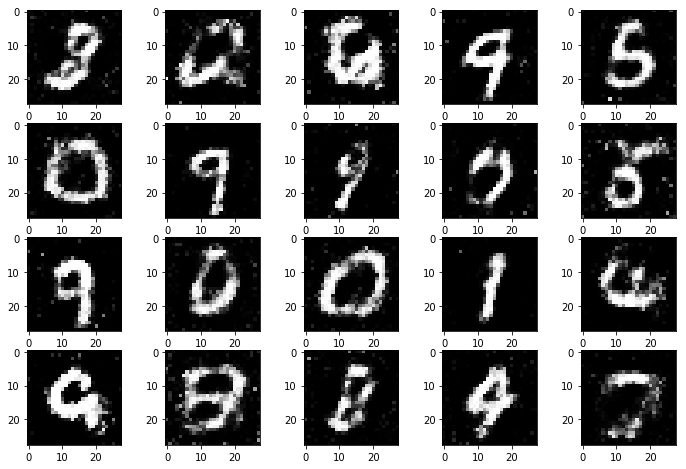

In [59]:
random_img =np.random.randint(0,np.array(l_img).shape[0])
print("Cada vez que se ejecute muestra una imagen aleatoria | epochs= ", random_img*100)
plt.figure(figsize=(12,8))
lote_img = np.array(l_img)[random_img]
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.imshow(lote_img[i].reshape(28,28), cmap="gray")